This notebook contains the code for creating layer wise causal traces of gpt2 models, and some observations from trying tracing on a variety of prompts.

All outputs have already been produced so there isn't a need to actually run anything if you just want to peruse the traces. 


# Setup and Functions (It will take a couple minutes to load the model)

## Imports and Defaults

In [ ]:
%pip install transformers
%pip install ipython-autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 5.2 MB/s 
     |████████████████████████████████| 120 kB 63.7 MB/s 
     |████████████████████████████████| 6.6 MB 35.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 5.2 MB/s 


For timing cell execution

In [ ]:
%load_ext autotime

time: 372 µs (started: 2022-08-26 09:51:11 +00:00)


Imports

In [ ]:
import torch
import torch.nn.functional as F
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, set_seed
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm, Normalize
import numpy as np


time: 7.29 s (started: 2022-08-26 09:51:11 +00:00)


Torch settings

In [ ]:
# set seed for random, numpy and torch
set_seed(1)

# set default device to GPU
torch.set_default_tensor_type('torch.cuda.FloatTensor') 

# disable gradient tracking (we won't be using it)
torch.set_grad_enabled(False) 

time: 12 ms (started: 2022-08-26 09:51:18 +00:00)


## Functions

### Basic Functions for Handling Model Output

In [ ]:
# ------ Model Tokenizer Object -------

class ModelWithTokenizer:
    """
  This object takes a Hugging Face model string as input and stores the
  corresponding model, tokenizer and other properties for easy access.

  On initialisation, will also try to move model to GPU if available.
  """

    def __init__(self, model_str):
        self.model = AutoModelForCausalLM.from_pretrained(model_str)
        self.tokenizer = AutoTokenizer.from_pretrained(model_str)
        self.model_str = model_str
        self.n_embd = self.model.config.n_embd  # Length of embedding vector as int
        self.n_vocab = self.model.config.vocab_size  # Num possible tokens as int

        # Puts model onto GPU
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.model.to(self.device)


# ------ Call Model -------


def get_output(mt, input, full_output=False):
    """
  Returns model output given a ModelWithTokenizer object and an input.
  
  Input can be either a prompt string or raw input embeddings (tensor)
  Input embedding shape is (num_tokens, n_embd_dims)

  'full_output' controls what information is included in the model output
  """

    # If full output is wanted, setup verbose kwargs for call
    if full_output is True:
        verbose_kwargs = {
            "output_hidden_states": True,
            "use_cache": True,
            "output_attentions": True,
        }
    else:
        verbose_kwargs = {}

    # If the input is a string, tokenize and then run forward pass
    if isinstance(input, str):
        encoded_input = mt.tokenizer(input, return_tensors="pt")
        return mt.model(**encoded_input, **verbose_kwargs)

    # If the input is already an embedding, just run forward pass
    if isinstance(input, torch.Tensor):
        return mt.model(inputs_embeds=input, **verbose_kwargs)


# ------ Managing Output Logits and Probs -------


def get_logits(mt, input):
    """
  Return model logits on each possible token for each token in input.
  """
    return get_output(mt, input).logits


def get_probs_from_logits(logits, token_idx=-1, dim=1):
    """
  Given logits, return probabilities of each possible token for each token in input.
  Uses softmax.
  """
    return F.softmax(logits[:, token_idx, :], dim=dim)


# ------ Most Likely Next Token and Prob -------


def get_next_token_and_prob(mt, input):
    """
  Returns a tuple of the most likely next word(s) and their probabilities.
  """
    logits = get_logits(mt, input)

    probs = get_probs_from_logits(logits, -1, dim=1)

    max_prob, max_idx = torch.max(probs, dim=1)
    next_token = mt.tokenizer.decode(max_idx)

    return next_token, max_prob


# ------ Probs of paticular tokens -------


def get_prob_for_token_id(mt, input, token_id, token_idx=-1):
    """
  Given a token id, return the probability of outputting that paticular token at
  a paticular position (defaults position is next word).
  """
    logits = get_logits(mt, input)
    probs = get_probs_from_logits(logits, token_idx=-1)
    return probs[:, token_id]


def get_prob_for_token(mt, input, token, token_idx=-1):
    """
  Given a token as a string, return the probability of outputting that paticular token at
  a paticular position (defaults position is next word).
  """
    token_id = mt.tokenizer(token).input_ids
    return get_prob_for_token_id(mt, input, token_id, token_idx=token_idx)


# ------ Quick next word -------


def get_text_completion(mt, input_str):
    """
  Return the most likely next word along with the original prompt.
  """
    next_token, _ = get_next_token_and_prob(mt, input_str)
    return input_str + next_token



time: 6.94 ms (started: 2022-08-26 09:51:18 +00:00)


### Handling Model Input

In [ ]:
# ------ Handling Tokens -------


def get_token_list(mt, input_str):
    """
  Given an input string, return a list of token strings that make up the
  input.
  """
    input_ids = mt.tokenizer(input_str).input_ids
    token_list = [mt.tokenizer.decode(token_id) for token_id in input_ids]
    return token_list


def get_num_tokens(mt, input_str):
    """
  Given an input string, return the number of tokens it contains.
  """
    return len(get_token_list(mt, input_str))


# ------ Get Embeddings -------


def get_prompt_embedding(mt, input_str):
    """
  Given an input string, return the input embeddings.
  """
    input_ids = torch.tensor(mt.tokenizer([input_str]).input_ids)

    embedding_func = mt.model.get_input_embeddings()

    return embedding_func(input_ids)



time: 3.21 ms (started: 2022-08-26 09:51:18 +00:00)


### Noising Input Embeddings

In [ ]:
# -------- Noising Embeddings -------


def noise_single_embedding(embedding, noise_std=0.1, noise_idxs=[]):
    """
  Adds gaussian noise with mean 0 and standard deviation noise_std to
  the noise_idxs in the embeddings. 
  If no noise_idxs are provided all token embeddings are noised.
  """
    
    # numpy noise generation 
    # noise = torch.tensor(np.random.randn(*list(embedding.size())) * noise_std).float()
    
    noise = torch.randn(embedding.size()) * noise_std
    noised_embedding = torch.clone(embedding).detach()

    for idx in noise_idxs:
        noised_embedding[:, idx, :] = embedding[:,idx,:] + noise[:,idx,:]

    return noised_embedding


def noise_embeddings(mt, embedding, n, noise_std=0.1, noise_idxs=[]):
    """
  Adds gaussian noise with mean 0 and standard deviation noise_std to
  the noise_idxs in the embeddings. 
  If n is more than 1 returns a list of differently noised versions of the embedding of length num.
  If no noise_idxs are provided all token embeddings are noised.
  """
    '''
  if n == 1:
      return noise_single_embedding(embedding)
  elif n > 1:
  '''
    noisy_embeds_list = []
    for i in range(n):
        noisy_embed = noise_single_embedding(
            embedding, noise_std=noise_std, noise_idxs=noise_idxs
        )

        noisy_embeds_list.append(noise_single_embedding(
            embedding, noise_std=noise_std, noise_idxs=noise_idxs
        ))

    noisy_embeds_tensor = torch.stack(noisy_embeds_list).reshape(n, -1, mt.n_embd)
    return noisy_embeds_tensor
    '''
    else:
        raise ValueError("n must be positive integer")
        '''

time: 8.22 ms (started: 2022-08-26 09:51:18 +00:00)


### Patching Hidden States

In [ ]:
# ------ Get List of Layers of Type -------


def get_target_layers(model, target_layer_type):
    """
  Given a model and a target layer type, return a list of all layers in the model of that type.
  """
    target_layer_list = []

    for layer in model.modules():
        if isinstance(layer, target_layer_type):
            target_layer_list.append(layer)

    return target_layer_list

time: 941 µs (started: 2022-08-26 09:51:18 +00:00)


In [ ]:
class PatchHidden:
    """
  Patches in a 'clean' hidden state of the network from a 'clean' forward pass
  at the corresponding token and layer.

  Call is a pre forward hook.
  """

    def __init__(self, clean_hidden_states, token_idx, layer_idx):
        # Store where hook is to be inserted for later recall.
        self.clean_hidden_states = clean_hidden_states
        self.token_idx = token_idx
        self.layer_idx = layer_idx
        return

    def __call__(self, module, module_in):
        # Replace the current input hidden state with the corresponding 'clean' hidden state
        self.new_hidden = torch.clone(module_in[0])
        self.new_hidden[:, self.token_idx, :] = self.clean_hidden_states[
            self.layer_idx
        ][:, self.token_idx, :]
        return self.new_hidden


def remove_all_hooks(hook_handles):
    """
  Given a list of hook handle objects, remove every single asssociated hook.
  """
    for my_handle in hook_handles:
        my_handle.remove()

    hook_handles = []
    return hook_handles


def patch_hiddens(
    mt,
    clean_input,
    comparison_input,
    batch_size=1,
    target_layer_type=transformers.models.gpt2.modeling_gpt2.GPT2Block,
):
    """
  Given a clean input and a comparison input (which can be a string or a tensor of embeddings),
  this function will go through every (token, layer) pair of the model - patch
  it's input hidden state at the target layers, and record how this changes the probability
  of the original top word on the clean input still being the top word on the comparison input.
  """

    # Get clean output which includes all hidden states
    clean_outputs = get_output(mt, clean_input, full_output=True)

    # Get clean most likely next word
    clean_word, _ = get_next_token_and_prob(mt, clean_input)

    # Retrieve target layers to hook.
    target_layers = get_target_layers(mt.model, target_layer_type)

    # Initialise tensor to store values from runs.
    num_tokens = get_num_tokens(mt, clean_input)
    probs = torch.zeros((batch_size, num_tokens, len(target_layers)))

    hook_handles = []

    # For every token in the prompt and target layer...
    for token_idx in range(num_tokens):
        for layer_idx, layer in enumerate(target_layers):

            # Initialise the hook for this current token and target layer
            hook = PatchHidden(clean_outputs.hidden_states, token_idx, layer_idx)

            # Make and store a handle for the hook
            handle = layer.register_forward_pre_hook(hook)
            hook_handles.append(handle)

            # Run a batch through the hooked model and collet probs of most likely token
            probs[:, token_idx, layer_idx] = get_prob_for_token(
                mt, comparison_input, clean_word
            ).reshape(batch_size,)

            # Once we are done with the hooks for this token and layer, remove them.
            remove_all_hooks(hook_handles)

    return probs



def patch_hidden_states(
    mt,
    clean_input,
    batch_size,
    comparison_input_str=None,
    noise_std=0.1,
    noise_idxs=[0],
    target_layer_type=transformers.models.gpt2.modeling_gpt2.GPT2Block,
    patch_func=patch_hiddens,
    seed = 1
):

    """
  Convenience function for patching hidden state.
  
  Automatically creates noised embeddings if no comparison input string is given.
  """

    if seed != False:
      set_seed(seed)

    if comparison_input_str != None:
        comparison_input = comparison_input_str
    else:
        clean_embeds = get_prompt_embedding(mt, clean_input)
        comparison_input = noise_embeddings(
            mt, clean_embeds, batch_size, noise_std=noise_std, noise_idxs=noise_idxs
        )

    probs = patch_hiddens(
        mt,
        clean_input,
        comparison_input,
        batch_size=batch_size,
        target_layer_type=transformers.models.gpt2.modeling_gpt2.GPT2Block,
    )

    #clean_word, _ = get_next_token_and_prob(mt, clean_input)
    #base_corrupted_probs = get_prob_for_token(mt, comparison_input, clean_word).reshape((batch_size,1,1))
    #print(base_corrupted_probs[0])
    #print(base_corrupted_probs[1])

    #prob_diffs = probs - base_corrupted_probs

    return probs


time: 60.7 ms (started: 2022-08-26 09:51:18 +00:00)


### Plotting and Convenience Functions

In [ ]:
# These functions need rewriting...

def plot_trace(
    trace_probs,
    noise_idxs=[],
    batch_size=None,
    noise_std=None,
    mt=None,
    prompt=None,
    color="Purples",
    font_size = 22,
    size=30,
    log_colors=False,
    fig_ratio=0.7,
    clip_low = False,
    clip_color = 'white',
    vmin = None,
    vmax = None,
    max_at_clean_prob = False,
    mod_min_max = False
):
    
    n_tokens, n_layers = trace_probs.size()

    plot_probs = trace_probs.cpu().detach().numpy()
    
    plt.rcParams["font.family"] = "Gulasch", "Times", "Times New Roman", "serif"
    plt.rcParams['axes.linewidth'] = 2 

    title = ""
    if batch_size != None and noise_std != None:
        noise_std = round(noise_std, 3)
        title = f"Restoring input hidden state over {batch_size} noised runs \n (Gaussian noise with mean 0 and std {noise_std})"


    if font_size != None:
      plt.rcParams.update({"font.size": font_size})
      
    if log_colors == True:
        norm = LogNorm(vmin=np.min(plot_probs), vmax=np.max(plot_probs))
    else:
        norm = None

    if clip_low == True:
      norm = Normalize(vmin = plot_probs[0,0])
      cmap = plt.get_cmap(color)
      cmap.set_under(clip_color)
    else:
      cmap = color

    if vmin != None:
      norm = Normalize(vmin = vmin)
    elif vmax != None:
      norm = Normalize(vmax = vmax)

    if max_at_clean_prob == True:
      _ , clean_prob = get_next_token_and_prob(mt, prompt)
      norm = Normalize(vmax = clean_prob)

    if mod_min_max == True:
      _ , clean_prob = get_next_token_and_prob(mt, prompt)
      norm = Normalize(vmin = plot_probs[0,0],vmax = clean_prob)



    fig = plt.figure(figsize=(size, size * 0.5))
    ax = fig.add_subplot(111)
    ax.set_title(title, pad=20)
    im = ax.imshow(
        plot_probs,
        aspect= 8 * fig_ratio,
        interpolation="nearest",
        cmap=cmap,
        norm=norm,
        extent=[0, n_layers, n_tokens, 0]
    )

    # main ticks
    plt.xticks(np.arange(0, n_layers, 5))
    ax.yaxis.set_tick_params(width=3, length=10, pad = 10, labelsize = 'large')
    ax.xaxis.set_tick_params(width=3, length=10, pad = 10, labelsize = 'large')

    # main x axis
    ax.set_xlabel(f"Single patched layer in {mt.model_str}", labelpad = 15)

    # main y axis
    if prompt != None:
        token_list = get_token_list(mt, prompt)
        if noise_idxs != []:
            for idx in noise_idxs:
                token_list[idx] = token_list[idx] + "*"

        y_tick_positions = [i + 0.5 for i in range(len(token_list))]
        ax.set_yticks(y_tick_positions)
        ax.set_yticklabels(token_list)

    # colorbar axis
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="0.5%", pad="-40%")

    cbar = plt.colorbar(im, cax=cax)
    cbar.ax.get_yaxis().labelpad = 30

    if mt != None and prompt != None:
        clean_word, prob_original = get_next_token_and_prob(mt, prompt)
    
    if clean_word != None:
        cbar.ax.set_ylabel(f'p("{clean_word}")', rotation=270, labelpad = 40, fontsize = 28)
        cbar.ax.yaxis.set_tick_params(width=3, length=10, pad = 10, labelsize = 'large')


    return


def run_and_plot_trace(
    mt,
    input_str,
    batch_size=10,
    noise_idxs=[0],
    noise_std=0.1,
    seed=1,
    fig_ratio=0.7,
    size = 30,
    color="Purples",
    log_colors=False,
    clip_low = False,
    clip_color = 'white',
    output = False,
    vmin = None,
    vmax = None,
    max_at_clean_prob = False,
    mod_min_max = False
):


    outputs_to_plot = patch_hidden_states(
        mt, input_str, batch_size, noise_std=noise_std, noise_idxs=noise_idxs, seed = seed
    )

    mean_outputs_to_plot = torch.mean(outputs_to_plot, dim=0)

    plot_trace(
        mean_outputs_to_plot,
        mt=mt,
        prompt=input_str,
        batch_size=batch_size,
        noise_idxs=noise_idxs,
        color=color,
        size=size,
        fig_ratio=fig_ratio,
        noise_std=noise_std,
        log_colors=log_colors,
        clip_low = clip_low,
        clip_color = clip_color,
        vmin = vmin,
        vmax = vmax,
        max_at_clean_prob = max_at_clean_prob,
        mod_min_max = mod_min_max
    )

    if output == True:
      return outputs_to_plot
    else:
      return


    


time: 13 ms (started: 2022-08-26 11:54:08 +00:00)


## Loading model (will take a few minutes for GPT2-XL)

In [ ]:
# Other options include "gpt2" and "distilgpt2"

mt = ModelWithTokenizer("gpt2-xl")

time: 3min 12s (started: 2022-08-26 09:51:48 +00:00)


# **[REPLICATION]**

# Comparing My Own Causal Traces to Paper

I use torch random tensors rather than numpy so my random generation probably won't be exactly the same as the paper.

#### 1. "NTFS is developed by"

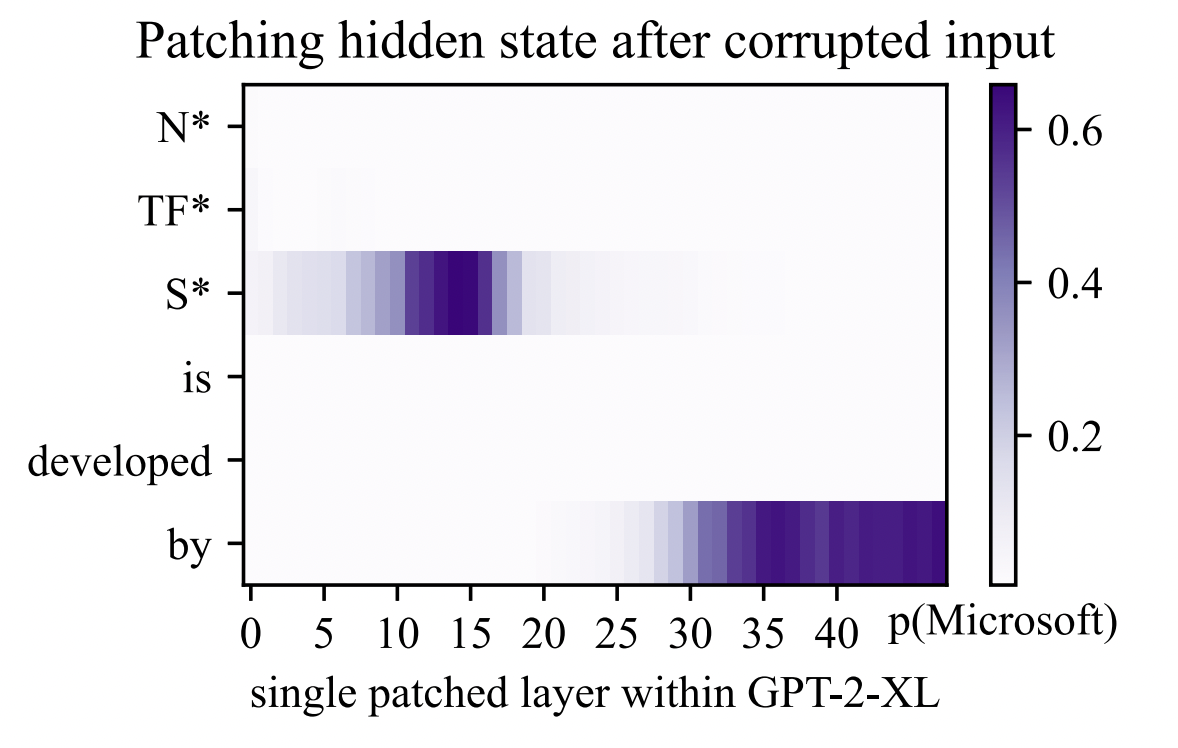

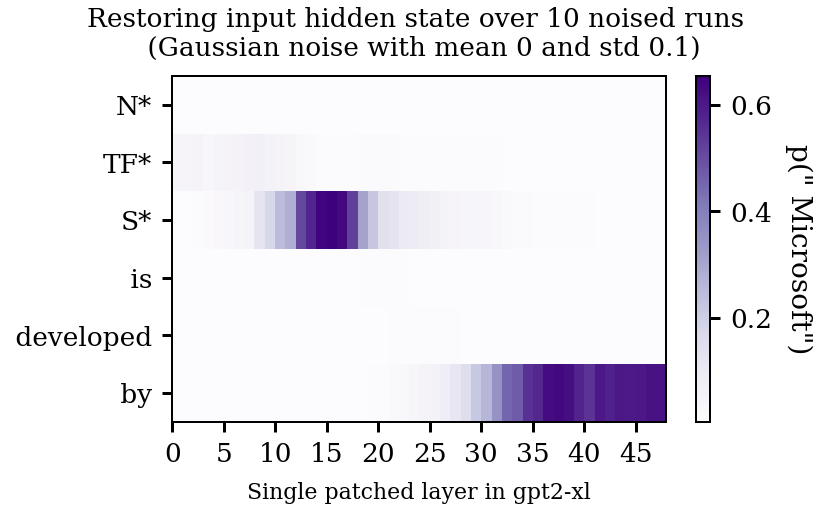

time: 15.7 s (started: 2022-08-25 21:45:09 +00:00)


In [ ]:
run_and_plot_trace(mt, "NTFS is developed by", noise_idxs = [0,1,2], noise_std = 0.1, batch_size = 10)



---



#### 2. "The Space Needle is in downtown"

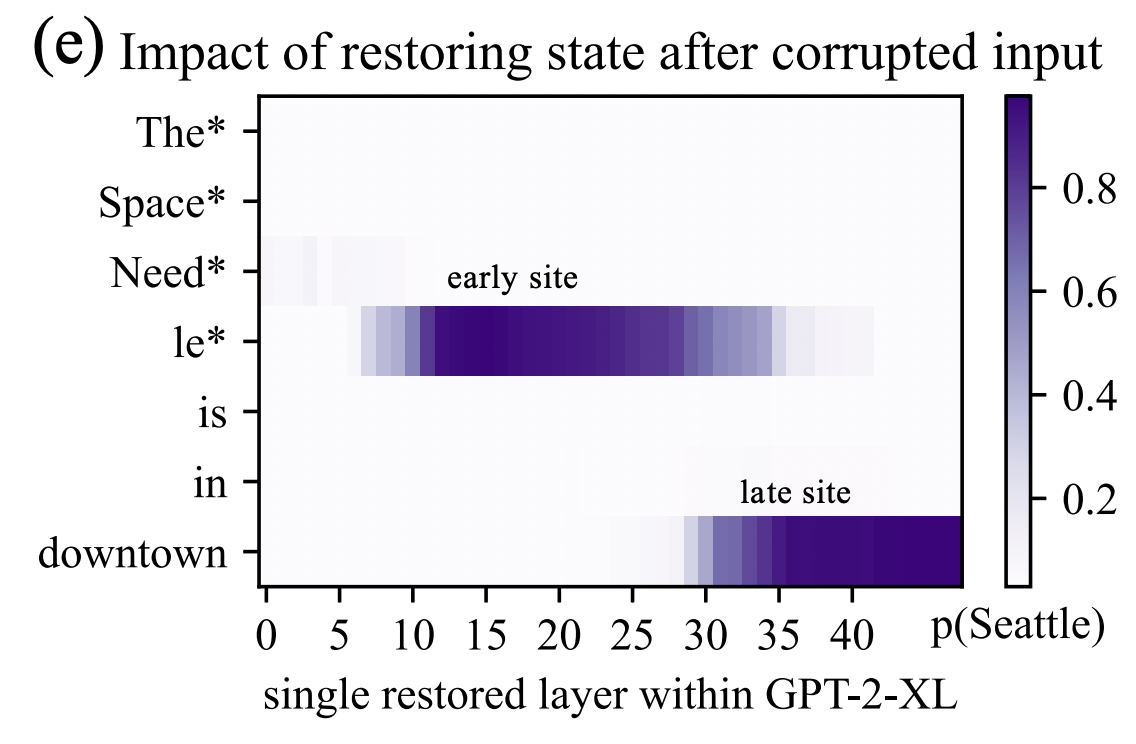

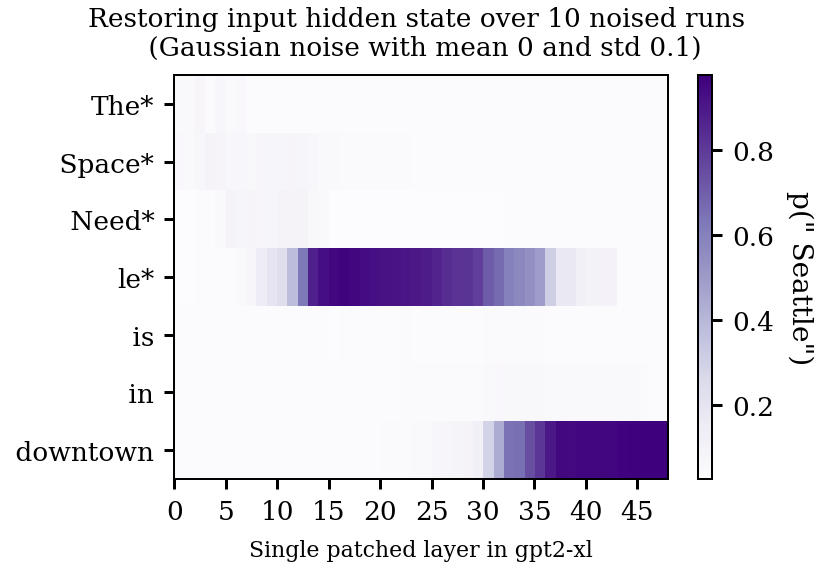

time: 25.1 s (started: 2022-08-25 20:31:00 +00:00)


In [ ]:
run_and_plot_trace(mt, "The Space Needle is in downtown", noise_idxs = [0,1,2,3], noise_std = 0.1, batch_size = 10)



---



#### 3. "The head quarter of Zillow is in downtown"

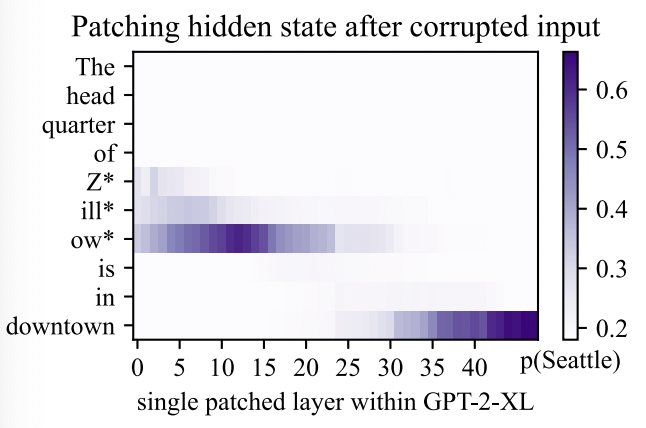

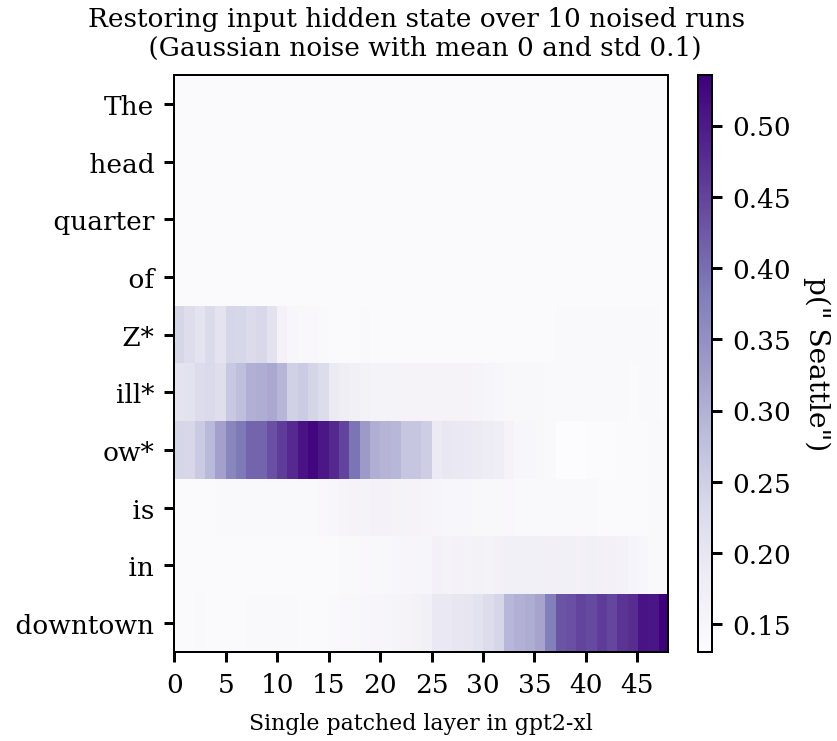

time: 42.4 s (started: 2022-08-25 20:36:10 +00:00)


In [ ]:
run_and_plot_trace(mt, "The head quarter of Zillow is in downtown", noise_idxs = [4,5,6], noise_std = 0.1, batch_size = 10)



---



#### 4. "Windows Media Player is developed by"

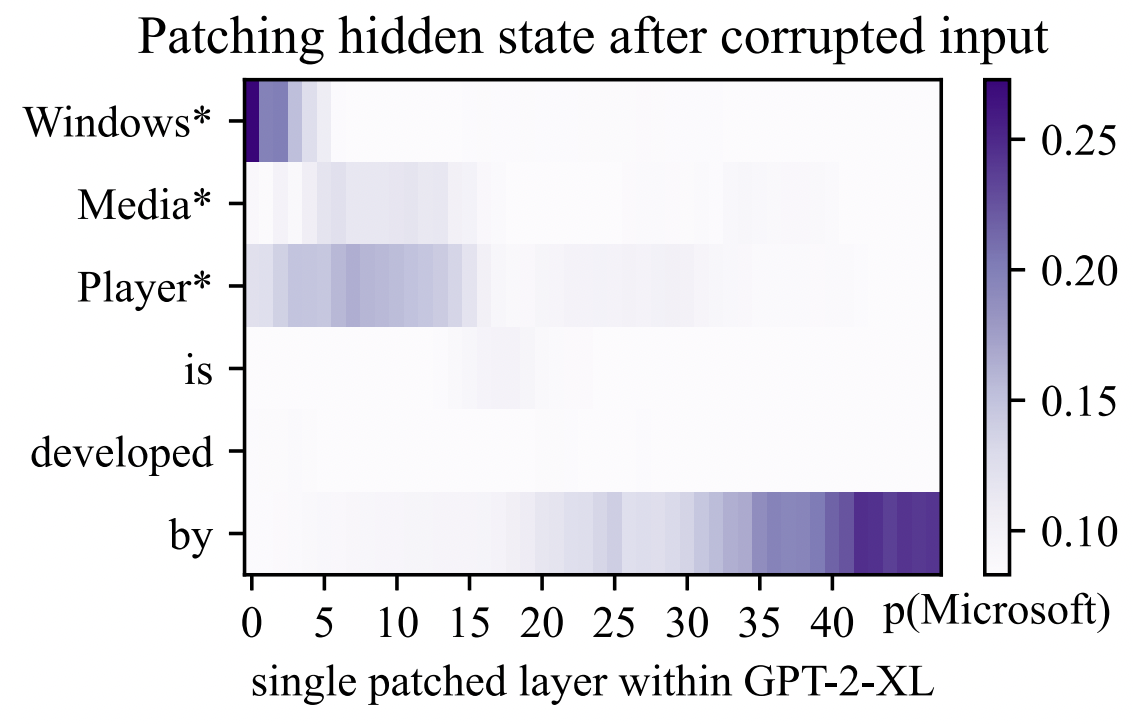

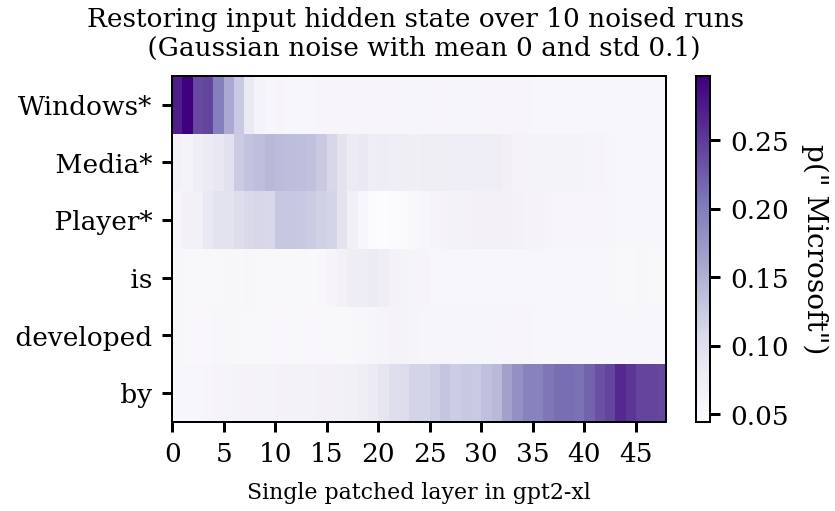

time: 16.2 s (started: 2022-08-25 21:27:42 +00:00)


In [ ]:
run_and_plot_trace(mt, "Windows Media Player is developed by", noise_idxs = [0,1,2], noise_std = 0.1, batch_size = 10)



---



#### 5. "Lexus's owner,"

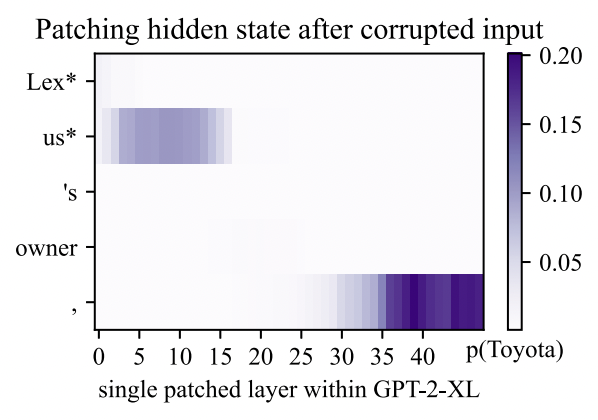![image.png]()

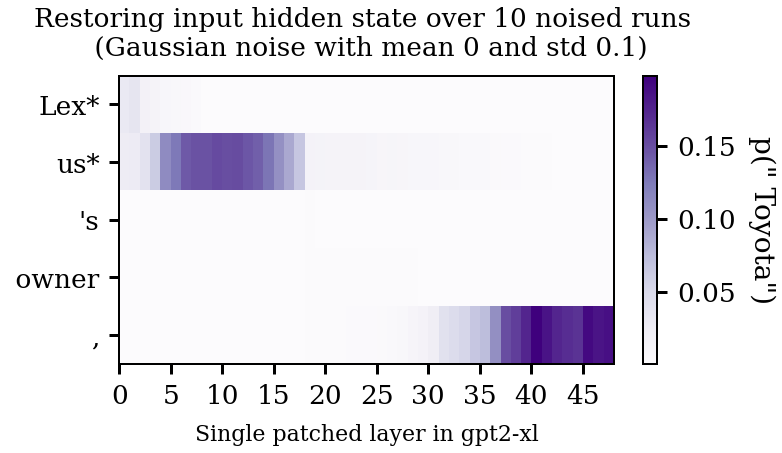

time: 13.5 s (started: 2022-08-25 21:30:05 +00:00)


In [ ]:
run_and_plot_trace(mt, "Lexus's owner,", noise_idxs = [0,1], noise_std = 0.1, batch_size = 10)

# **[SUMMARISED EXPERIMENTS]**

Quick disclaimer that any thoughts on these are very weakly held, I'd want to test a lot more examples before making any confident claims - but I do think some of my observations are interesting and suggestive.

# (A Quick Note on Choosing Noise Levels)

Traces seem sensitive to noise magnitude, but it is not obvious how to pick a noise level in a principled way.

The authors of the original paper state that their results are robust under different noise configurations. Perhaps my code is buggy but it at least seems like my causal traces are quite sensitive to noise magnitudes. I think by noise "configurations" they mean which tokens they are noising, rather than different noise distributions.

The authors in the original paper mention in the appendix that when they were testing other models besides GPT2-XL, they used a variance (standard deviation?) that matched the embedding magnitudes for these models. I am not sure if that is what they did for their traces with GPT2-XL. The whole variance / standard deviation mix up makes this a bit confusing and it isn't very clear to me how to choose the noise level in a principled way. This is doubly true since I suspect that in some cases the noise magnitude might change the shape of the traces quite a bit.

I've included some examples below of what varying noise level tends to look like, one without any scaling, and one with the minimum and maximum probabilities set to the probability of an unpatched model outputting the correct token for corrupt and clean input embeddings respectively. This scaling helps with displaying causal traces as the probability range changes but has the unfortunate consequence of clipping probabilities that are outside this range - and I think it can sometimes be misleading (sometimes there are patches that strongly lower the probability of outputting the correct token when patched for instance).

In light of all this, for now I have just chosen to default to displaying the raw mean output probabilties over a range of noise levels. This means that sometimes some traces will look weird (usually because the noise level is too low and the probability range has got quite small). Generally my view is that tracecs with wider probability ranges are better, since they tend to have a higher signal to noise ratio.



## Varying Noise Level Examples

### Varying Noise Level With No Scaling

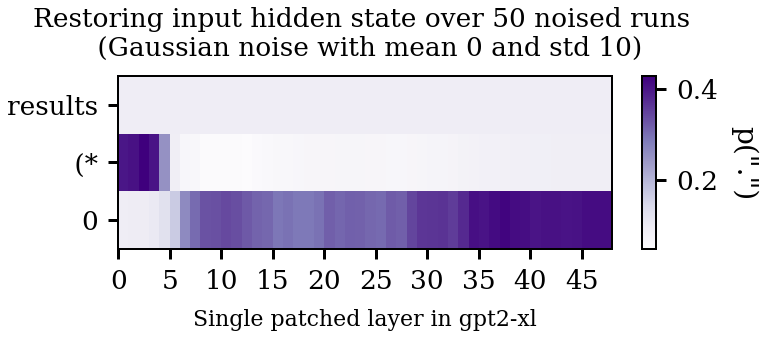

time: 18.6 s (started: 2022-08-26 00:04:10 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "results (0",
                   noise_idxs = [1],
                   noise_std = 10, batch_size = 50)

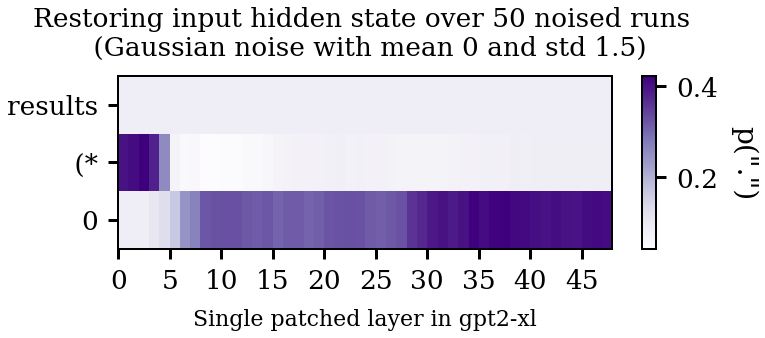

time: 18.1 s (started: 2022-08-26 00:03:21 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "results (0",
                   noise_idxs = [1],
                   noise_std = 1.5, batch_size = 50)

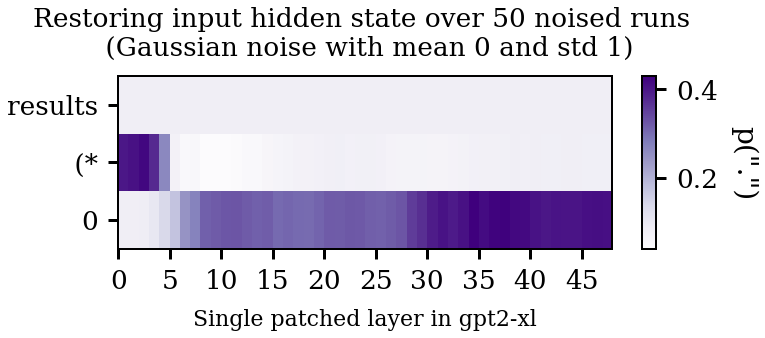

time: 17.9 s (started: 2022-08-25 22:07:21 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "results (0",
                   noise_idxs = [1],
                   noise_std = 1, batch_size = 50)

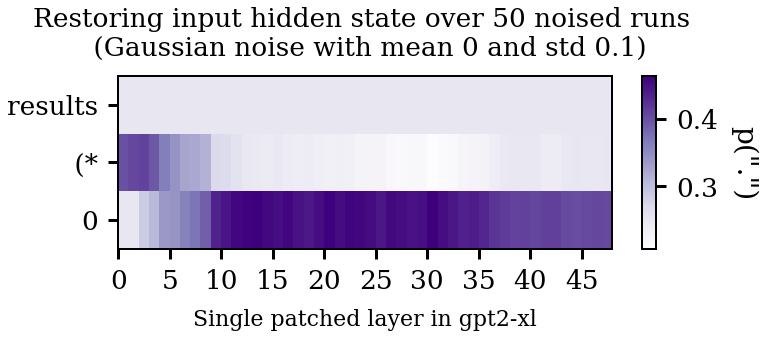

time: 17.9 s (started: 2022-08-25 22:07:39 +00:00)


In [ ]:
 run_and_plot_trace(mt,
                   "results (0",
                   noise_idxs = [1],
                   noise_std = 0.1, batch_size = 50)

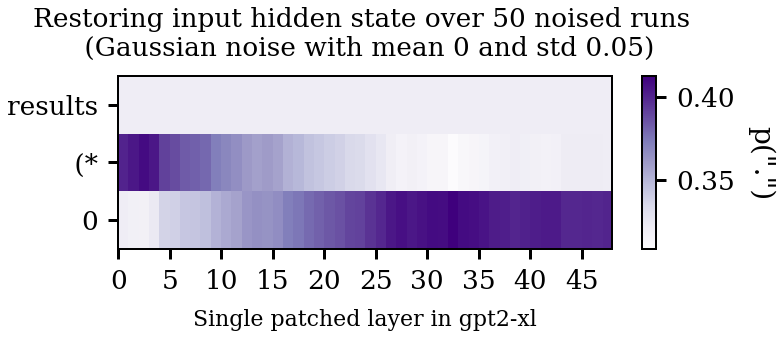

time: 18.9 s (started: 2022-08-26 00:00:45 +00:00)


In [ ]:
 run_and_plot_trace(mt,
                   "results (0",
                   noise_idxs = [1],
                   noise_std = 0.05, batch_size = 50)

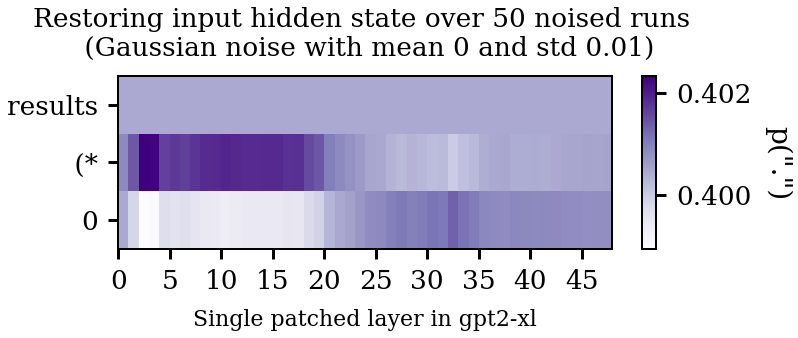

time: 18.9 s (started: 2022-08-25 22:04:23 +00:00)


In [ ]:
 run_and_plot_trace(mt,
                   "results (0",
                   noise_idxs = [1],
                   noise_std = 0.01, batch_size = 50)

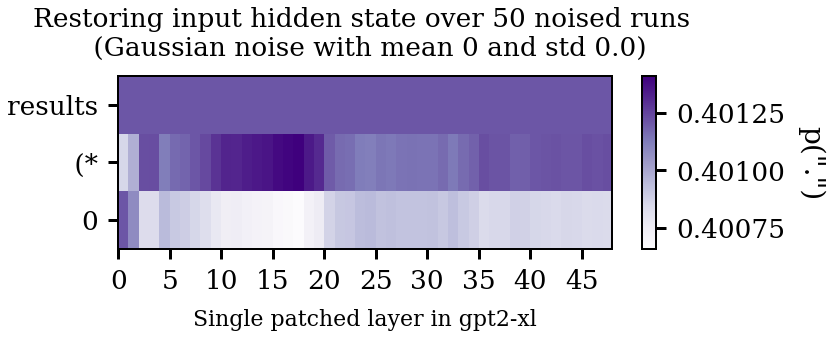

time: 18 s (started: 2022-08-26 00:05:23 +00:00)


In [ ]:
 run_and_plot_trace(mt,
                   "results (0",
                   noise_idxs = [1],
                   noise_std = 0.004, batch_size = 50)

### Varying Noise Level With scaling based on prob of correct token being predicted by unpatched model on clean and noised inputs [need to check scaling]

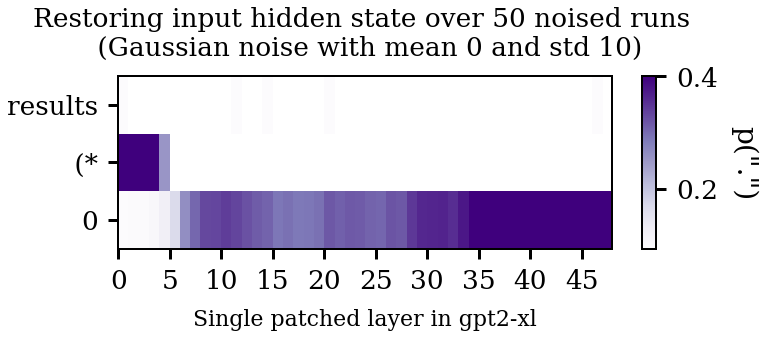

time: 18.2 s (started: 2022-08-26 00:56:47 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "results (0",
                   noise_idxs = [1],
                   noise_std = 10, batch_size = 50, mod_min_max = True)

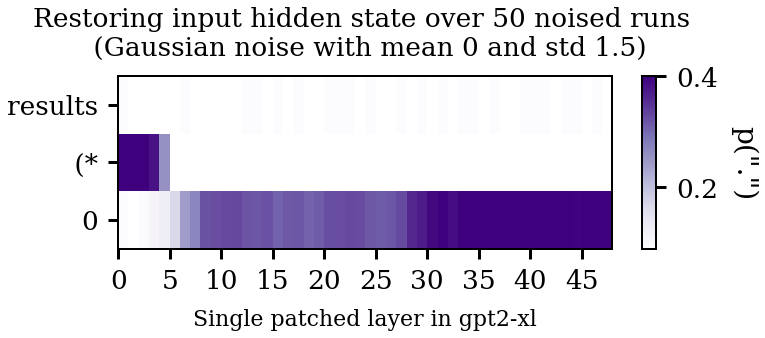

time: 17.9 s (started: 2022-08-26 00:57:06 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "results (0",
                   noise_idxs = [1],
                   noise_std = 1.5, batch_size = 50, mod_min_max = True)

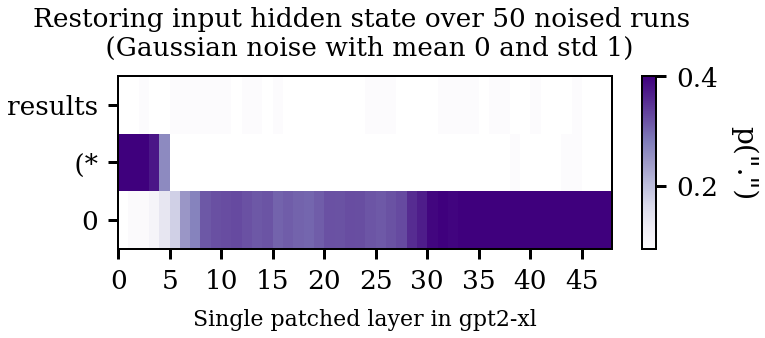

time: 18 s (started: 2022-08-26 00:57:24 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "results (0",
                   noise_idxs = [1],
                   noise_std = 1, batch_size = 50, mod_min_max = True)

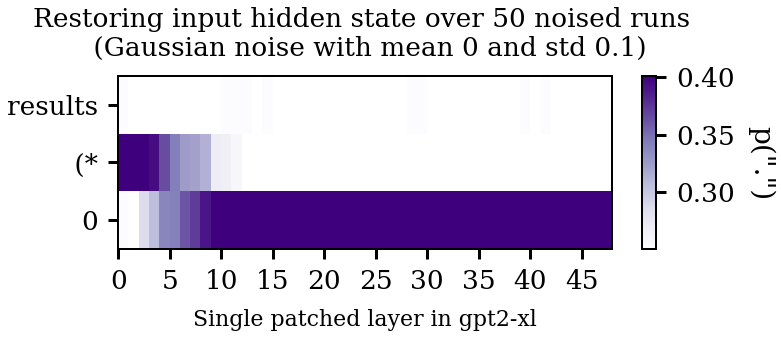

time: 18.1 s (started: 2022-08-26 00:57:42 +00:00)


In [ ]:
 run_and_plot_trace(mt,
                   "results (0",
                   noise_idxs = [1],
                   noise_std = 0.1, batch_size = 50, mod_min_max = True)

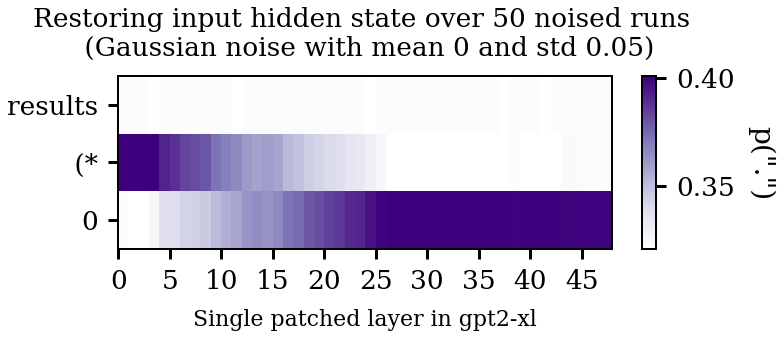

time: 18 s (started: 2022-08-26 00:58:00 +00:00)


In [ ]:
 run_and_plot_trace(mt,
                   "results (0",
                   noise_idxs = [1],
                   noise_std = 0.05, batch_size = 50, mod_min_max = True)

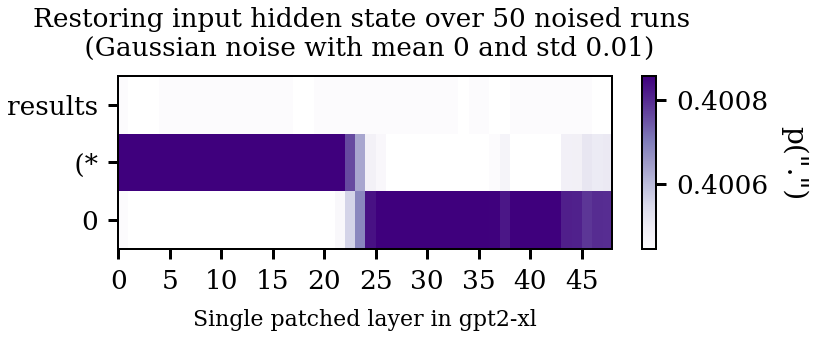

time: 18.2 s (started: 2022-08-26 00:58:18 +00:00)


In [ ]:
 run_and_plot_trace(mt,
                   "results (0",
                   noise_idxs = [1],
                   noise_std = 0.01, batch_size = 50, mod_min_max = True)

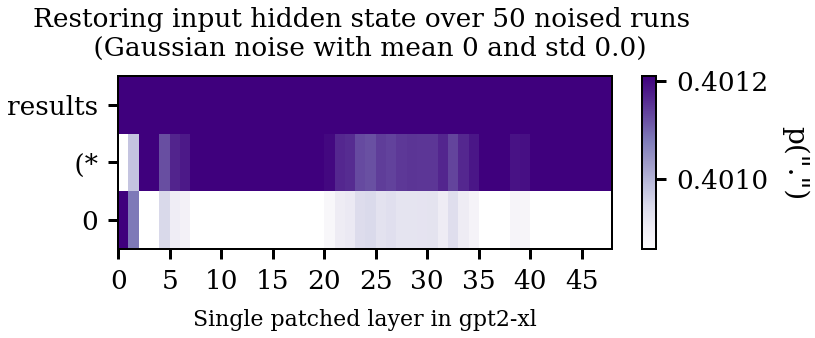

time: 18 s (started: 2022-08-26 00:58:36 +00:00)


In [ ]:
 run_and_plot_trace(mt,
                   "results (0",
                   noise_idxs = [1],
                   noise_std = 0.004, batch_size = 50, mod_min_max = True)

At what layer most information is transfered to later tokens seems to be related to complexity of information transfered. Simpler information seems like it is harvested by attention at earlier layers.

i.e Attention seems like it harvests information from earlier tokens in earlier layers when dealing with simpler information. 

=> Simpler information about previous tokens stored in earlier layers of the network? (seems plausible)

# Complexity and Info Transfer Layer

It seems like the layer at which the last token retrieves relevant information from previous tokens has a relationship to the complexity of the information being retrieved. Specifically, it seems like earlier layers contain simpler information and later layers contain more 'complex' information - like semantic information and associations.

[Speculation] I wonder if the layers build up some kind of internal semantic representation of the current token in the context of previous tokens such that the later layers contain a more nuanced, context specific representation of the information available?


It would be nice to test this with a prompt that requires retrieving simple information from one token and 'complex' semantic information from another - and then seeing what happens when one is noised and not the other. My current model would predict that noising the simple token would lead to a causal trace in which the noised information is handed off to the last token earlier than if the complex token was noised.

## Summary Examples (mild cherry picking)

Examples at a range of noise levels because it's difficult to pick a noise level in a principled way, and results can be sensitive to it. Often the lowest noise level is too low. Traces with wider probability ranges will tend to have higher signal to noise ratios.

Examples are ordered by roughly what layer that the relevant info from the noised token is 'looked up' by the attention of the last token

### Pi Recall (~ layer 5 - 10 )?

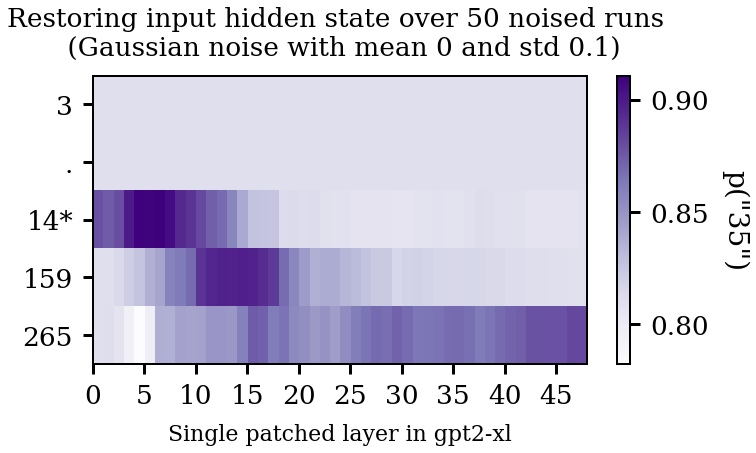

time: 36.2 s (started: 2022-08-26 11:57:02 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "3.14159265",
                   noise_idxs = [2],
                   noise_std = 0.1, batch_size = 50)

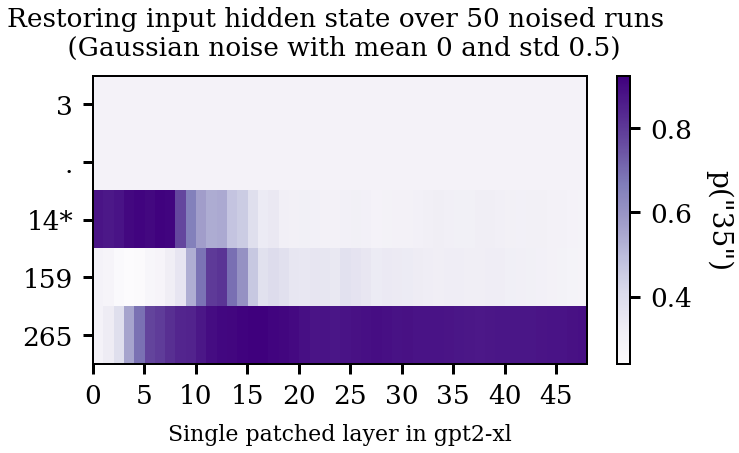

time: 36.2 s (started: 2022-08-26 11:57:38 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "3.14159265",
                   noise_idxs = [2],
                   noise_std = 0.5, batch_size = 50)

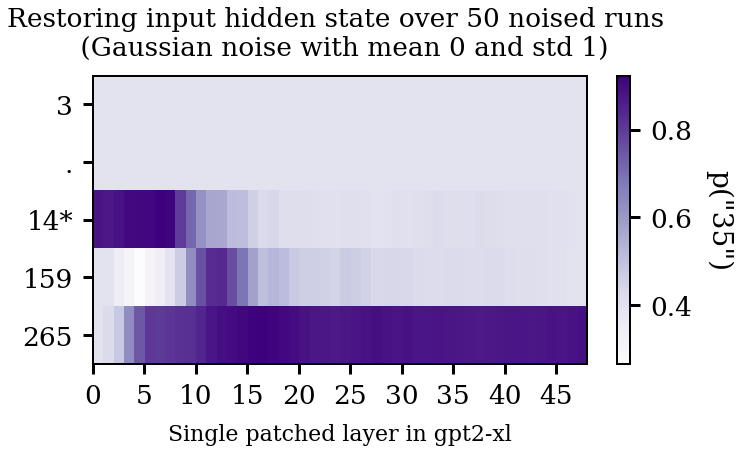

time: 36.7 s (started: 2022-08-26 00:13:33 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "3.14159265",
                   noise_idxs = [2],
                   noise_std = 1, batch_size = 50)

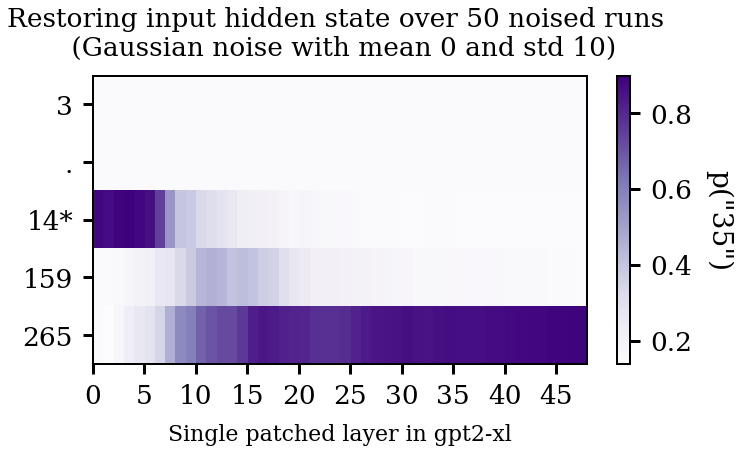

time: 35.9 s (started: 2022-08-26 00:14:09 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "3.14159265",
                   noise_idxs = [2],
                   noise_std = 10, batch_size = 50)

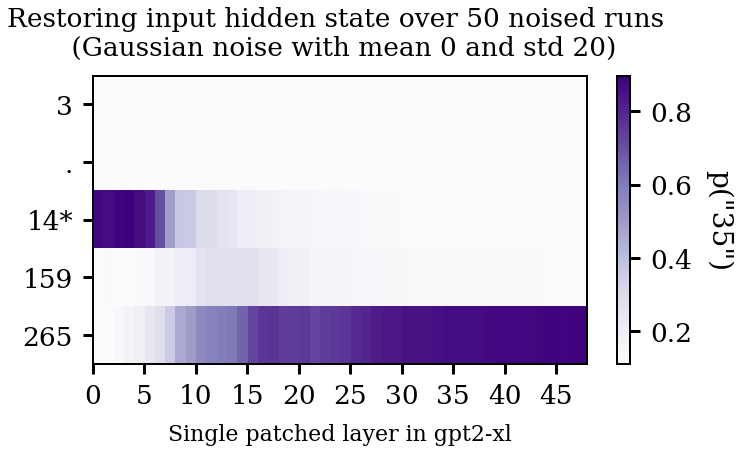

time: 36 s (started: 2022-08-26 00:14:45 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "3.14159265",
                   noise_idxs = [2],
                   noise_std = 20, batch_size = 50)

### Shortened Pi Recall (~ layer 5)

Interestingly the model will predict a continuation of pi after just seeing 159,265

In [ ]:
get_next_token_and_prob(mt, "159265")

('35', tensor([0.3772]))

time: 73.9 ms (started: 2022-08-26 13:57:28 +00:00)


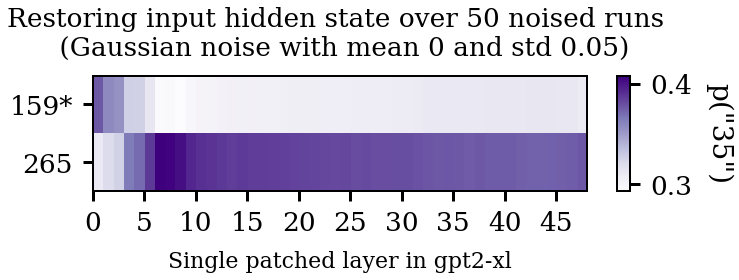

time: 9.38 s (started: 2022-08-26 13:59:45 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "159265",
                   noise_idxs = [0],
                   noise_std = 0.05, batch_size = 50)

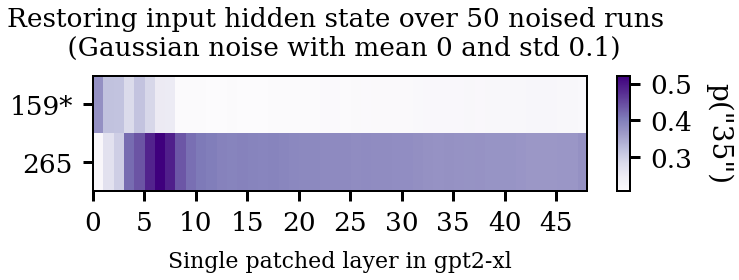

time: 8.69 s (started: 2022-08-26 13:58:45 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "159265",
                   noise_idxs = [0],
                   noise_std = 0.1, batch_size = 50)

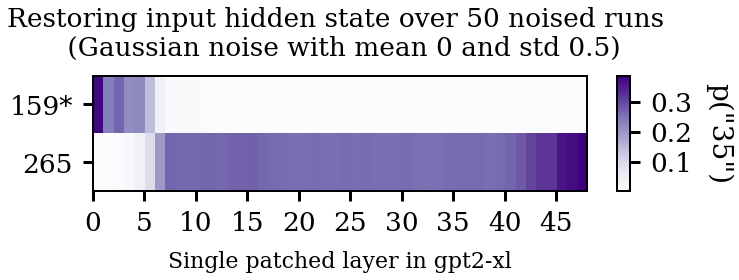

time: 8.7 s (started: 2022-08-26 14:00:24 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "159265",
                   noise_idxs = [0],
                   noise_std = 0.5, batch_size = 50)

### (Common Non-Plain English) About X results (center ~ layer 5 - 10)?

Google searches display this text: "About X results (0.X seconds)" So I would expect the model to have seen this a lot and be able to regurgitate it.

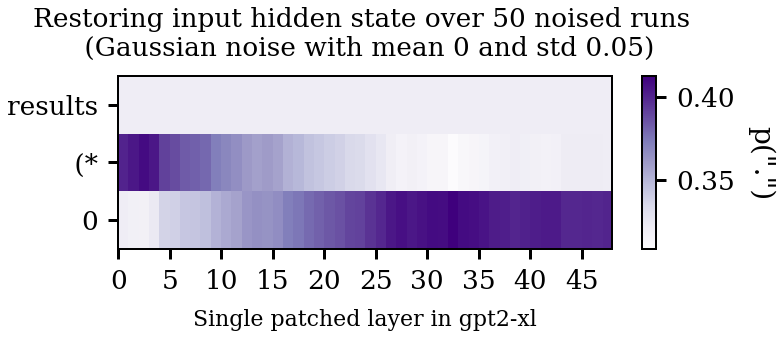

time: 18.1 s (started: 2022-08-26 11:32:37 +00:00)


In [ ]:
 run_and_plot_trace(mt,
                   "results (0",
                   noise_idxs = [1],
                   noise_std = 0.05, batch_size = 50)

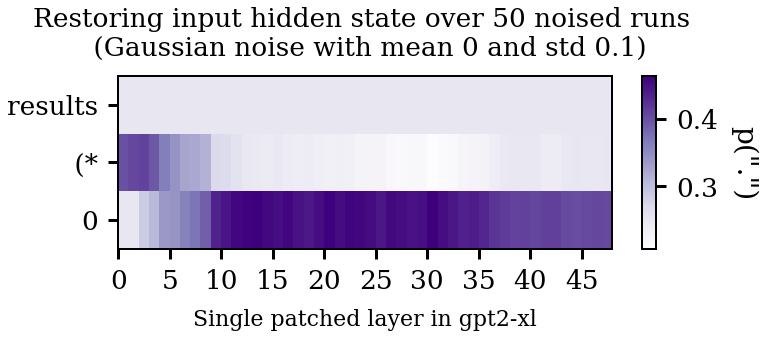

time: 17.9 s (started: 2022-08-25 22:07:39 +00:00)


In [ ]:
 run_and_plot_trace(mt,
                   "results (0",
                   noise_idxs = [1],
                   noise_std = 0.1, batch_size = 50)

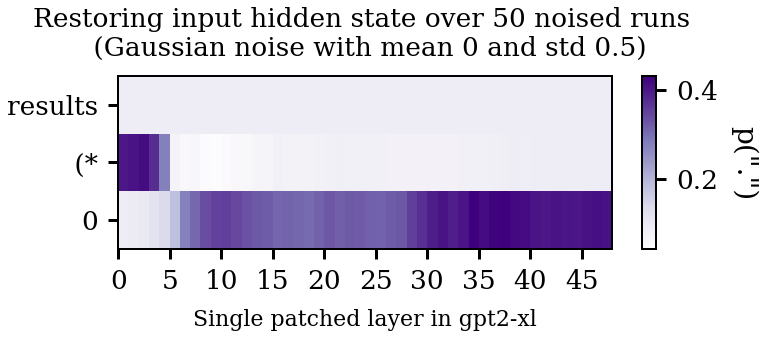

time: 18.2 s (started: 2022-08-26 11:32:55 +00:00)


In [ ]:
 run_and_plot_trace(mt,
                   "results (0",
                   noise_idxs = [1],
                   noise_std = 0.5, batch_size = 50)

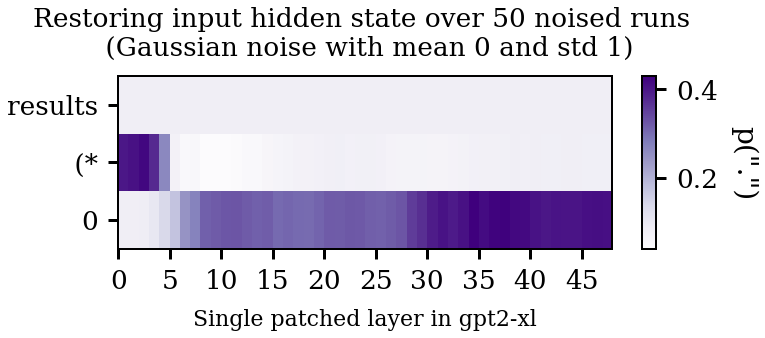

time: 18.5 s (started: 2022-08-26 11:58:14 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "results (0",
                   noise_idxs = [1],
                   noise_std = 1, batch_size = 50)

### (Common URL) .co. (center ~ layer 10)?

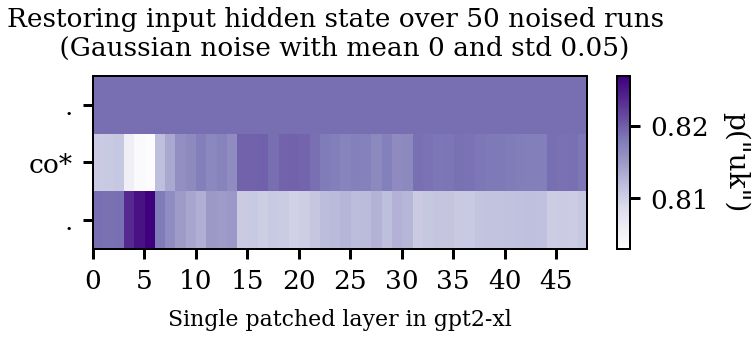

time: 19.1 s (started: 2022-08-26 11:31:22 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   ".co.",
                   noise_idxs = [1],
                   noise_std = 0.05,
                   batch_size = 50)

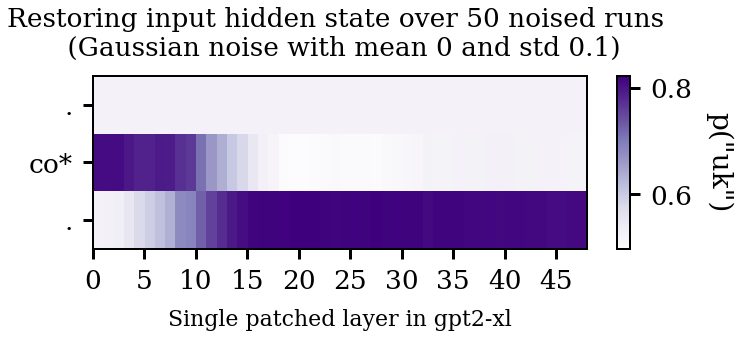

time: 18.5 s (started: 2022-08-26 11:09:08 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   ".co.",
                   noise_idxs = [1],
                   noise_std = 0.1,
                   batch_size = 50)

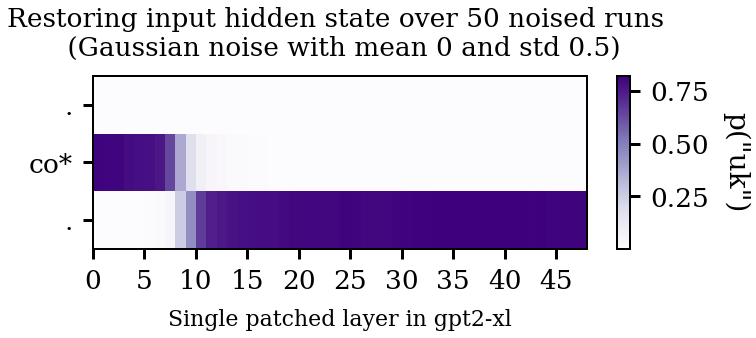

time: 18.4 s (started: 2022-08-26 11:31:41 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   ".co.",
                   noise_idxs = [1],
                   noise_std = 0.5,
                   batch_size = 50)

### (Positional Pattern) Almost Repitition ( ~ layer 5 - 15)?

Included additional high noise level for this one. (Note that first token is different to others)

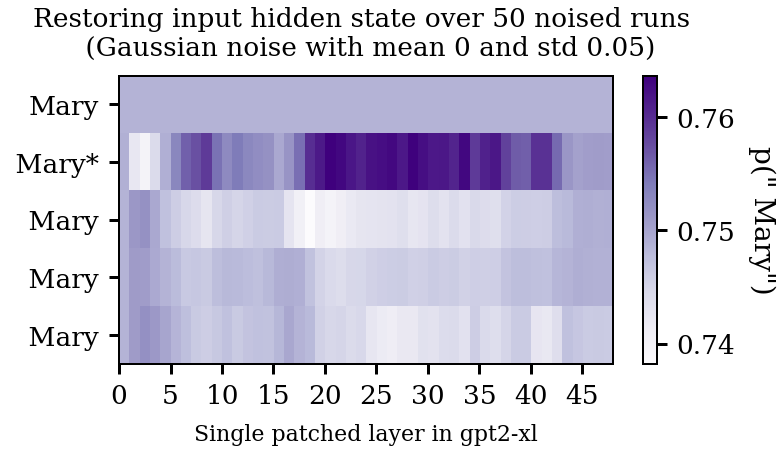

time: 36.2 s (started: 2022-08-26 12:51:13 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "Mary Mary Mary Mary Mary",
                   noise_idxs = [1],
                   noise_std = 0.05,
                   batch_size = 50)

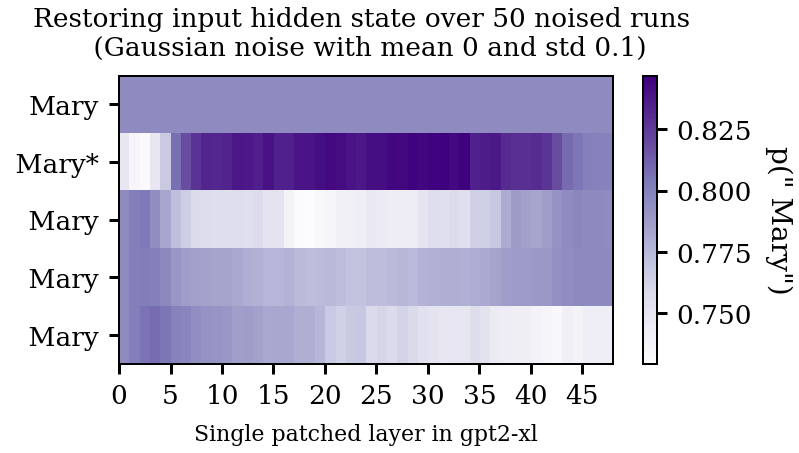

time: 37.8 s (started: 2022-08-26 12:49:59 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "Mary Mary Mary Mary Mary",
                   noise_idxs = [1],
                   noise_std = 0.1,
                   batch_size = 50)

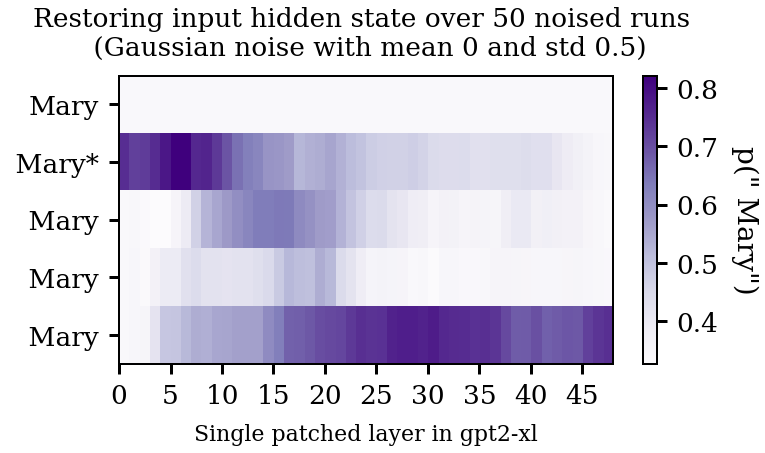

time: 36.2 s (started: 2022-08-26 12:50:37 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "Mary Mary Mary Mary Mary",
                   noise_idxs = [1],
                   noise_std = 0.5,
                   batch_size = 50)

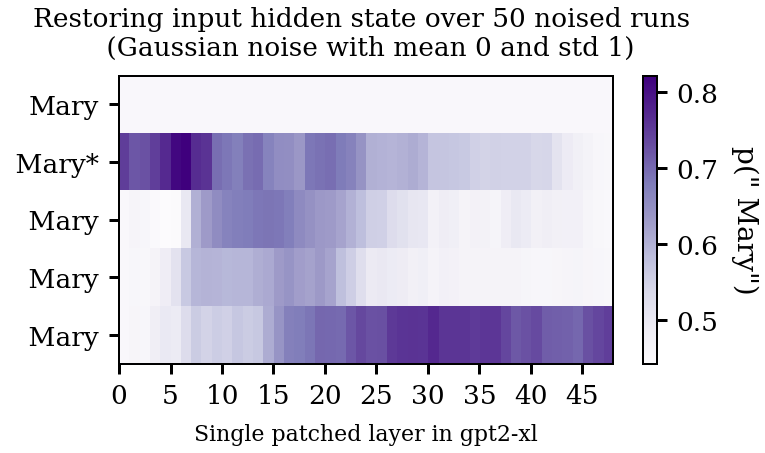

time: 37.4 s (started: 2022-08-26 12:56:23 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "Mary Mary Mary Mary Mary",
                   noise_idxs = [1],
                   noise_std = 1,
                   batch_size = 50)

### (Common URL) en.wikipedia. (center ~ layer 13)?

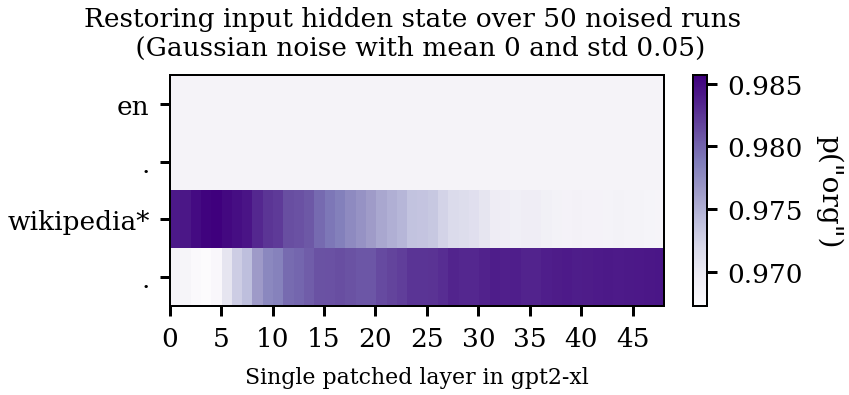

time: 28.1 s (started: 2022-08-26 11:29:27 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "en.wikipedia.",
                   noise_idxs = [2],
                   noise_std = 0.05, batch_size = 50)

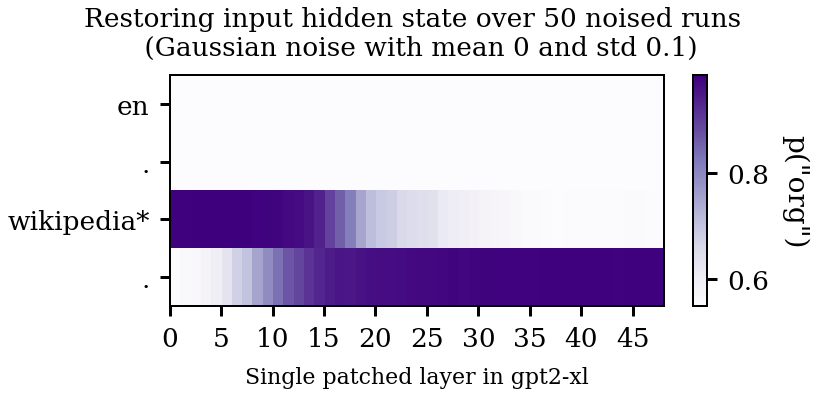

time: 27.7 s (started: 2022-08-26 00:19:18 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "en.wikipedia.",
                   noise_idxs = [2],
                   noise_std = 0.1, batch_size = 50)

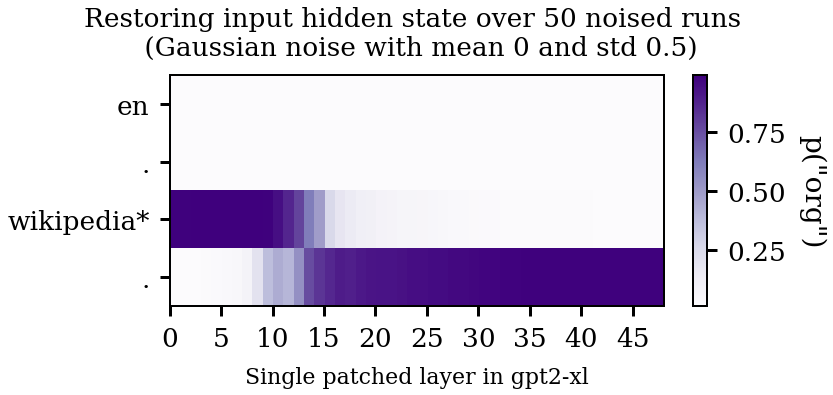

time: 27.5 s (started: 2022-08-26 00:20:10 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "en.wikipedia.",
                   noise_idxs = [2],
                   noise_std = 0.5, batch_size = 50)

### (Plain English Cached Phrases) This page was last edited (center at ~ layer 15)?

Common phrase on wikipedia

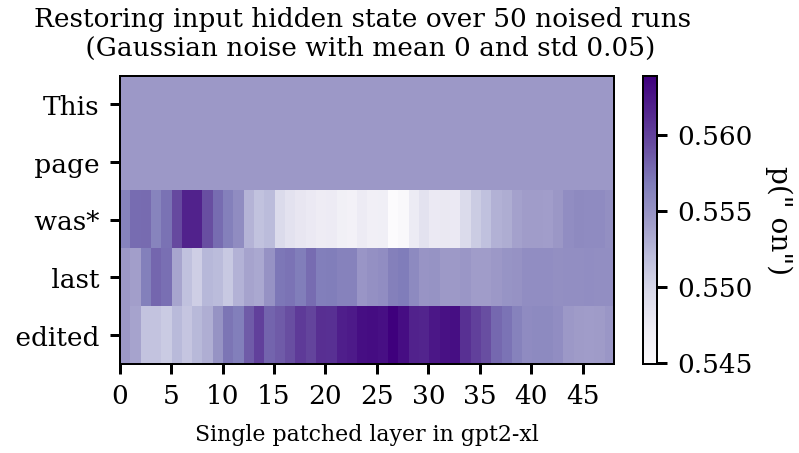

time: 37.1 s (started: 2022-08-26 12:59:23 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "This page was last edited",
                   noise_idxs = [2],
                   noise_std = 0.05,
                   batch_size = 50)

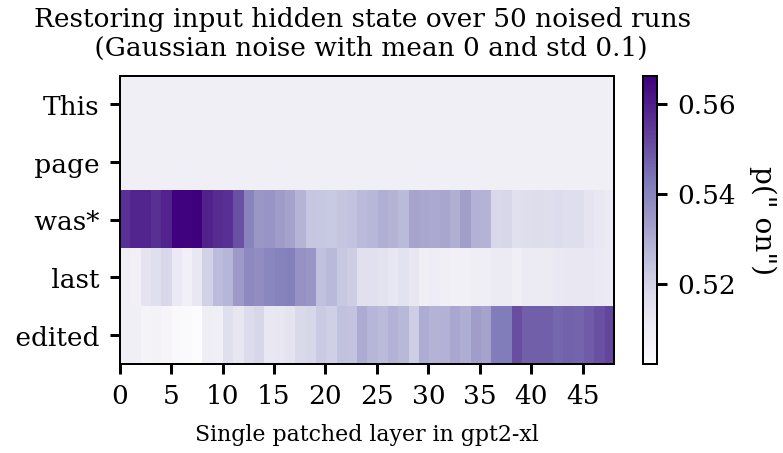

time: 36.5 s (started: 2022-08-26 12:58:46 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "This page was last edited",
                   noise_idxs = [2],
                   noise_std = 0.1,
                   batch_size = 50)

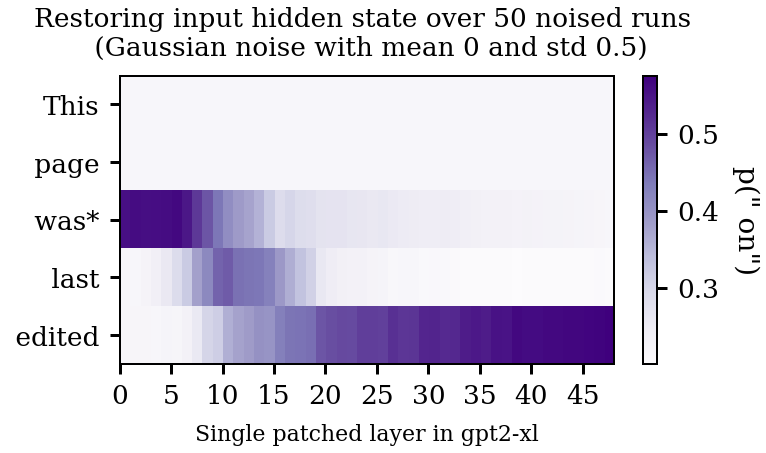

time: 37.6 s (started: 2022-08-26 12:58:09 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "This page was last edited",
                   noise_idxs = [2],
                   noise_std = 0.5,
                   batch_size = 50)

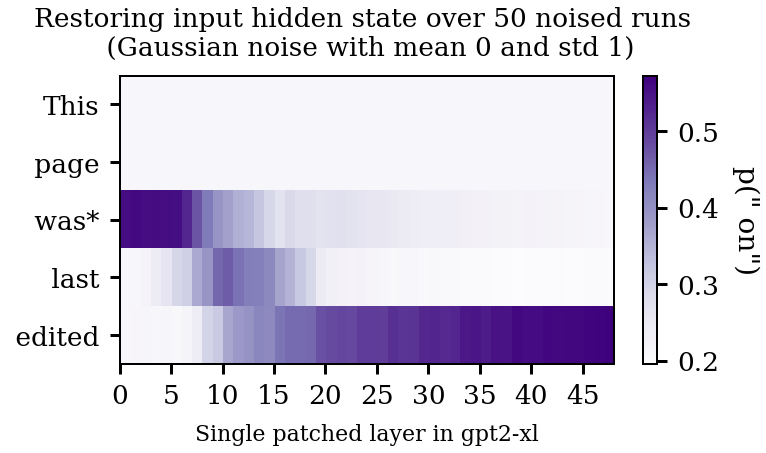

time: 37.9 s (started: 2022-08-26 13:00:34 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "This page was last edited",
                   noise_idxs = [2],
                   noise_std = 1,
                   batch_size = 50)

### (Plain English Cached Phrase) The BBC is not responsible for (center at ~ layer 17)?

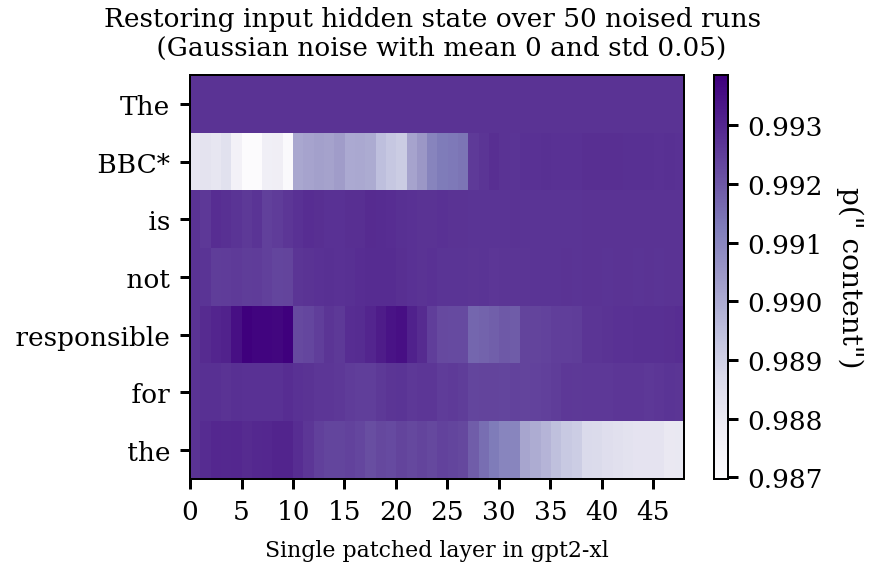

time: 1min 13s (started: 2022-08-26 13:02:05 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "The BBC is not responsible for the",
                   noise_idxs = [1],
                   noise_std = 0.05,
                   batch_size = 50)

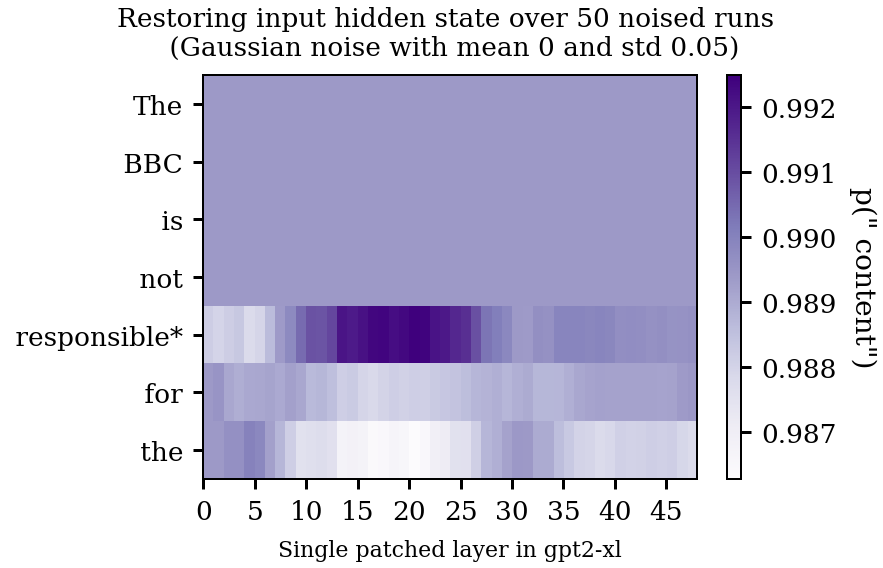

time: 1min 10s (started: 2022-08-26 13:03:19 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "The BBC is not responsible for the",
                   noise_idxs = [4],
                   noise_std = 0.05,
                   batch_size = 50)

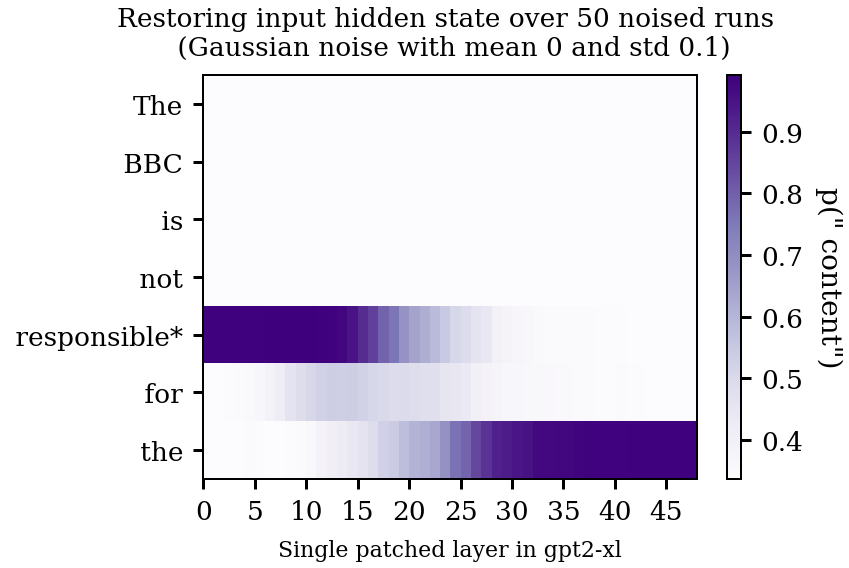

time: 1min 12s (started: 2022-08-26 13:04:29 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "The BBC is not responsible for the",
                   noise_idxs = [4],
                   noise_std = 0.1,
                   batch_size = 50)

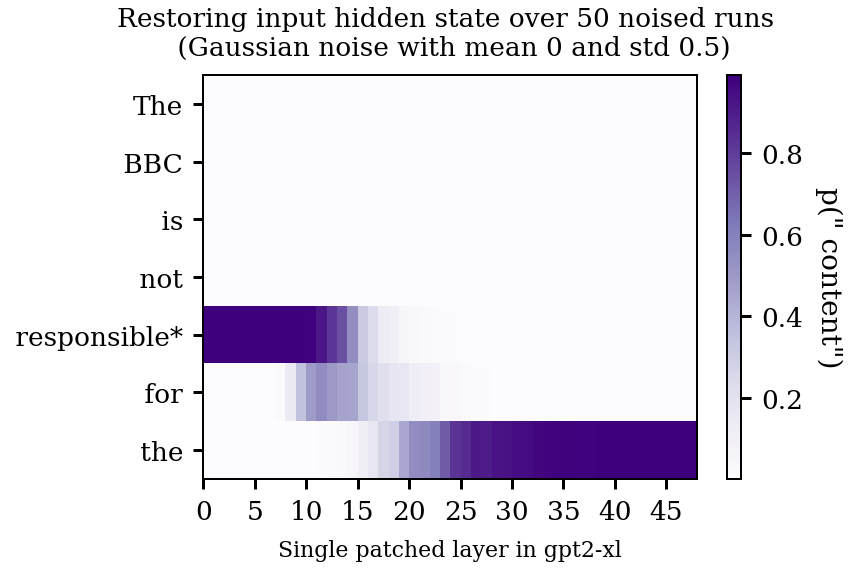

time: 1min 13s (started: 2022-08-26 13:05:42 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "The BBC is not responsible for the",
                   noise_idxs = [4],
                   noise_std = 0.5,
                   batch_size = 50)

### (Plain English Cached Phrase) From Wikipedia, the free (center at ~ layer 20)?

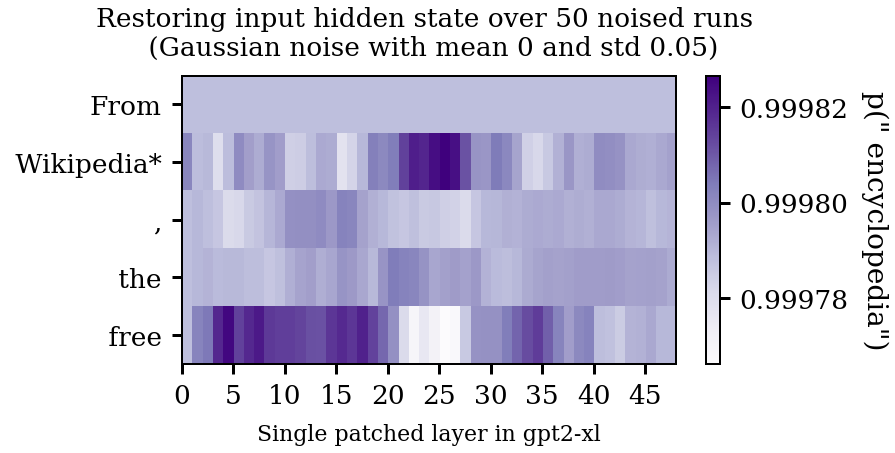

time: 36.6 s (started: 2022-08-26 12:03:25 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "From Wikipedia, the free",
                   noise_idxs = [1],
                   noise_std = 0.05, batch_size = 50)

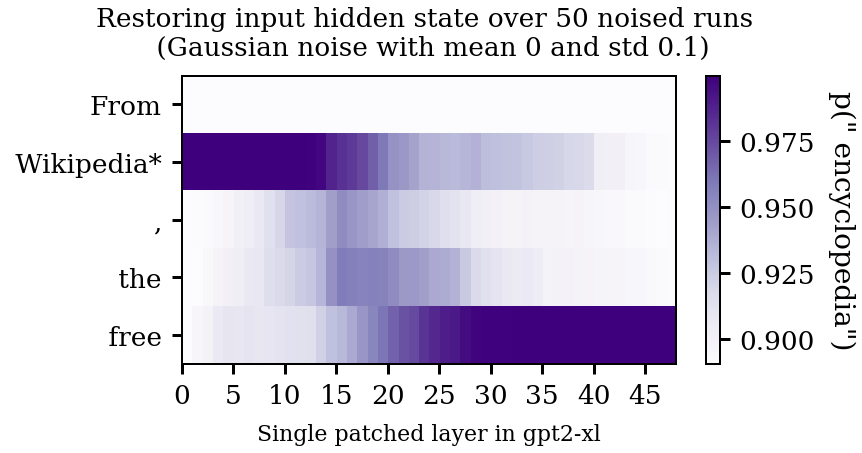

time: 36.6 s (started: 2022-08-26 12:02:49 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "From Wikipedia, the free",
                   noise_idxs = [1],
                   noise_std = 0.1, batch_size = 50)

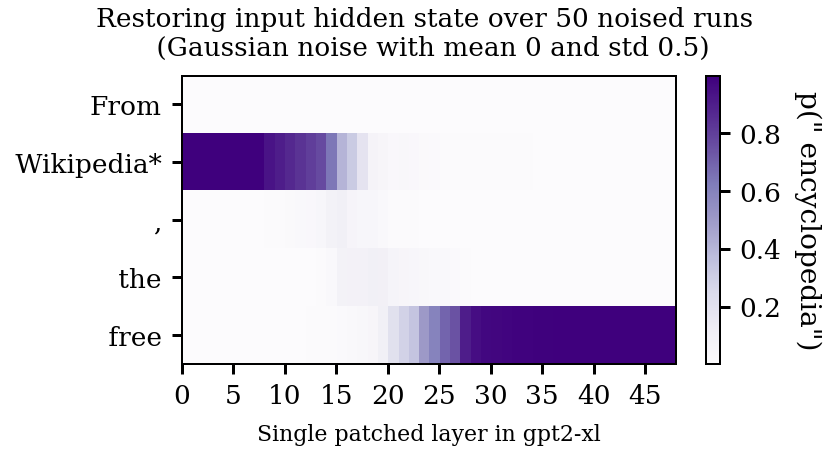

time: 38 s (started: 2022-08-26 12:02:11 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "From Wikipedia, the free",
                   noise_idxs = [1],
                   noise_std = 0.5, batch_size = 50)

### (Positional Pattern) Alternating tokens (~ layer 20)?

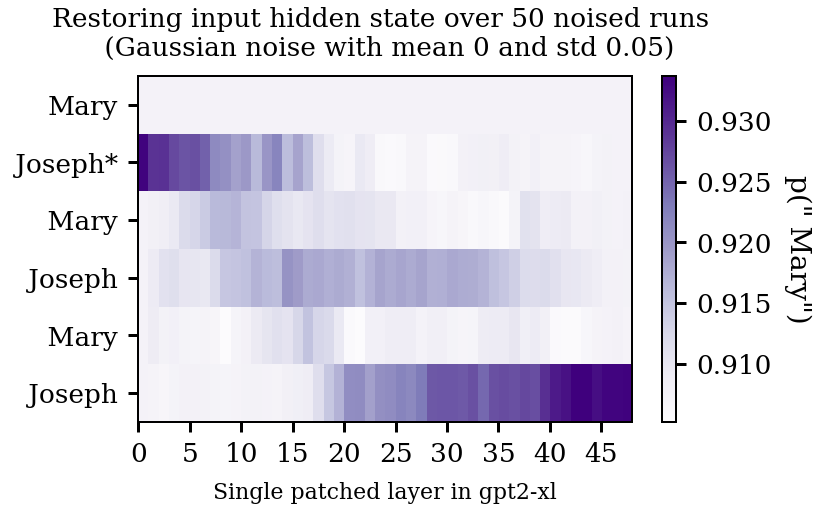

time: 56.2 s (started: 2022-08-26 12:40:19 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "Mary Joseph Mary Joseph Mary Joseph",
                   noise_idxs = [1],
                   noise_std = 0.05,
                   batch_size = 50)

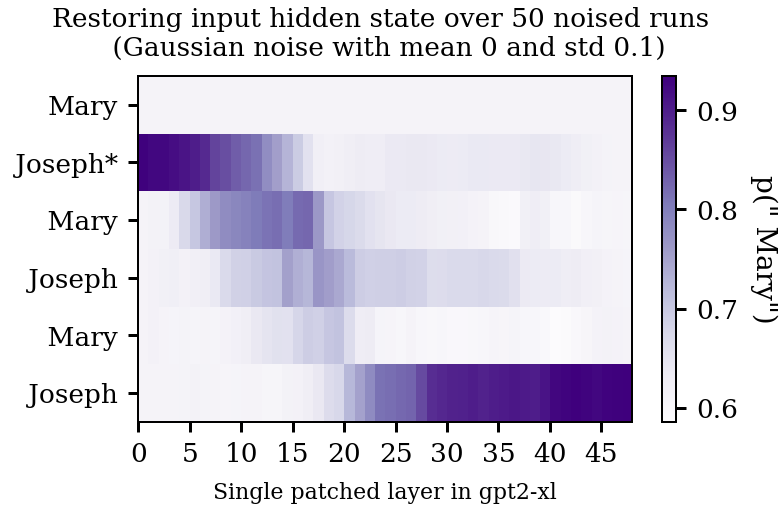

time: 56.4 s (started: 2022-08-26 12:39:22 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "Mary Joseph Mary Joseph Mary Joseph",
                   noise_idxs = [1],
                   noise_std = 0.1,
                   batch_size = 50)

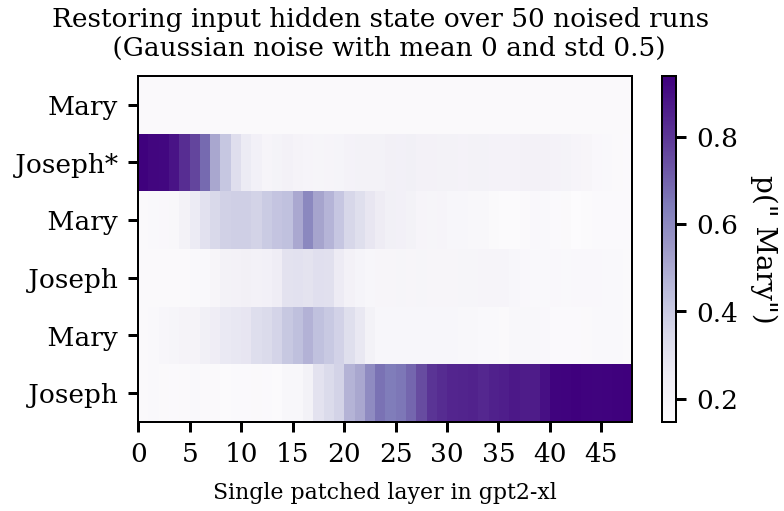

time: 56.2 s (started: 2022-08-26 12:38:26 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "Mary Joseph Mary Joseph Mary Joseph",
                   noise_idxs = [1],
                   noise_std = 0.5,
                   batch_size = 50)

### (Non Plain English Cache Phrase) import numpy as (layer 20 - 30)?

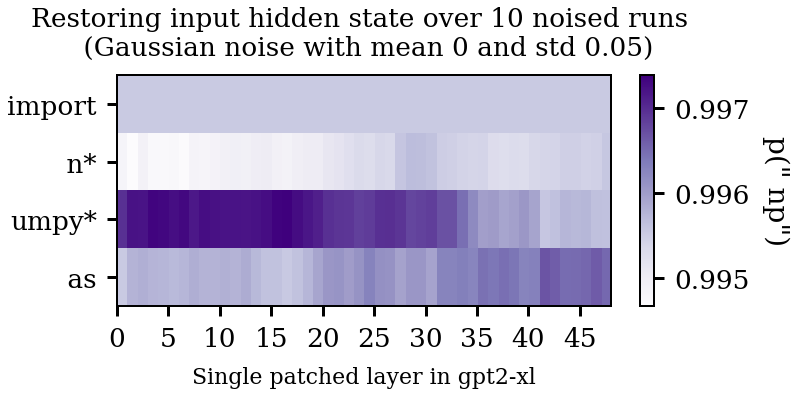

time: 10.4 s (started: 2022-08-26 13:06:55 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "import numpy as",
                   noise_idxs = [1,2],
                   noise_std = 0.05, batch_size = 50)

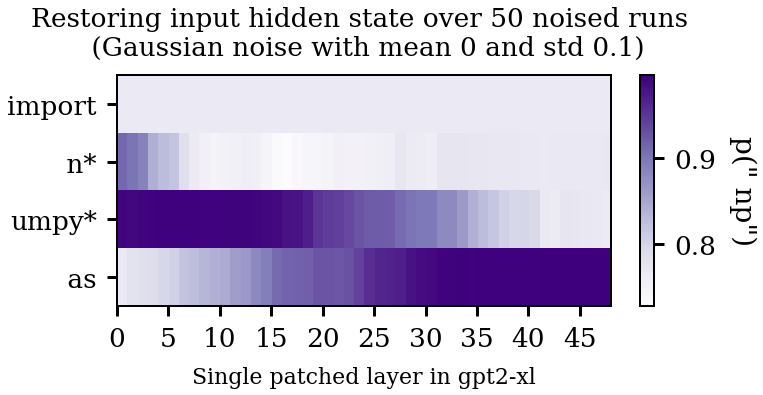

time: 27.5 s (started: 2022-08-26 13:07:06 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "import numpy as",
                   noise_idxs = [1,2],
                   noise_std = 0.1, batch_size = 50)

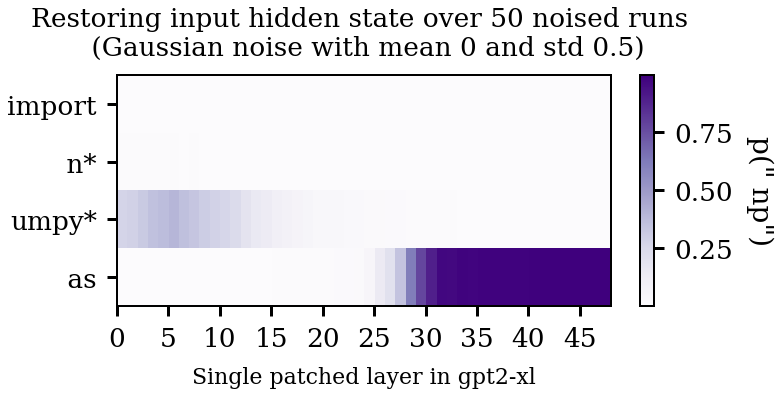

time: 27.9 s (started: 2022-08-26 13:07:34 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "import numpy as",
                   noise_idxs = [1,2],
                   noise_std = 0.5, batch_size = 50)

### (Facts) Elon Musk Birthplace (~ layer 30)?

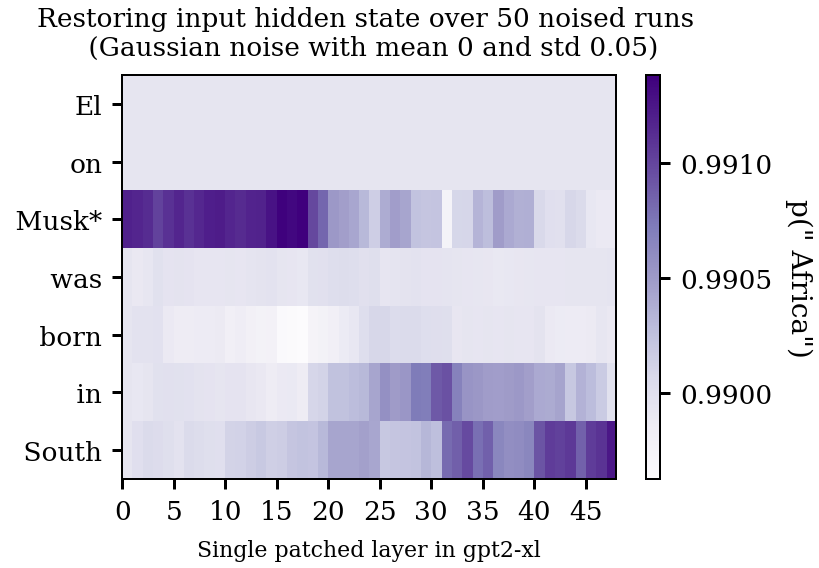

time: 1min 10s (started: 2022-08-26 13:21:05 +00:00)


In [ ]:
run_and_plot_trace(mt, "Elon Musk was born in South", noise_idxs = [2], noise_std = 0.05, batch_size = 50)

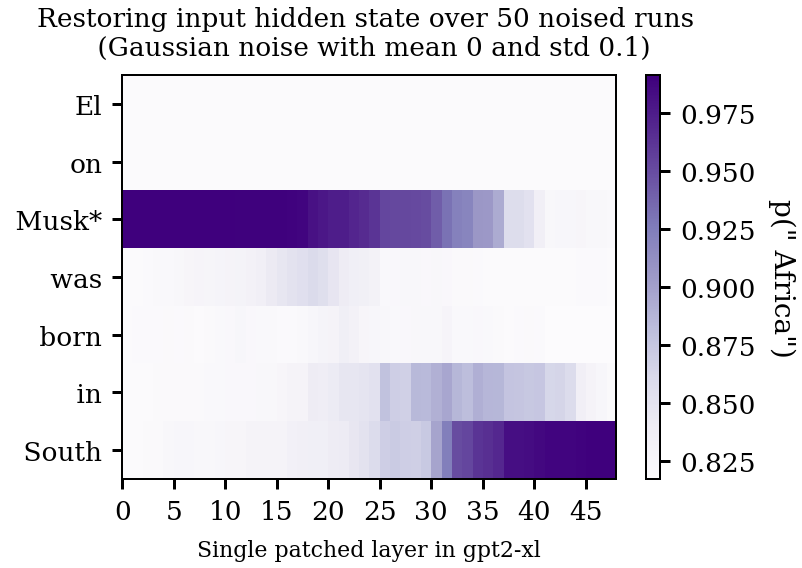

time: 1min 13s (started: 2022-08-26 13:22:16 +00:00)


In [ ]:
run_and_plot_trace(mt, "Elon Musk was born in South", noise_idxs = [2], noise_std = 0.1, batch_size = 50)

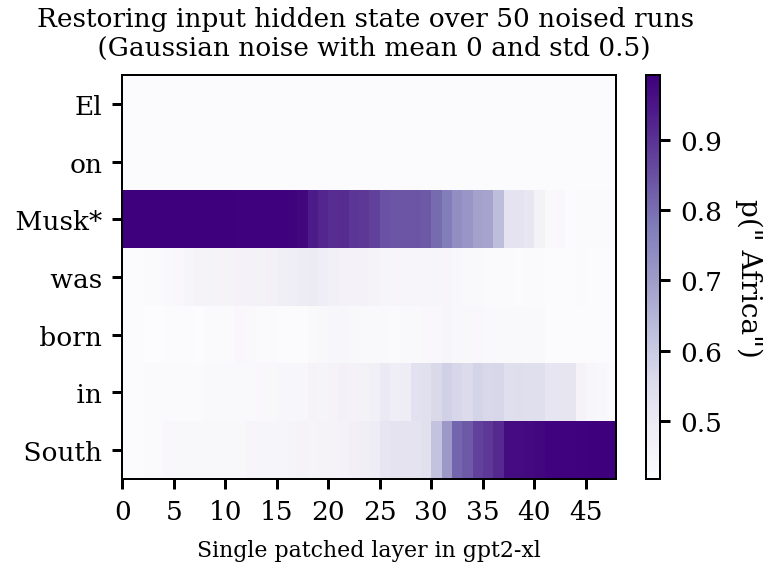

time: 1min 11s (started: 2022-08-26 13:23:29 +00:00)


In [ ]:
run_and_plot_trace(mt, "Elon Musk was born in South", noise_idxs = [2], noise_std = 0.5, batch_size = 50)

### (Facts) Eiffel Tower ( ~ layer 30 )?

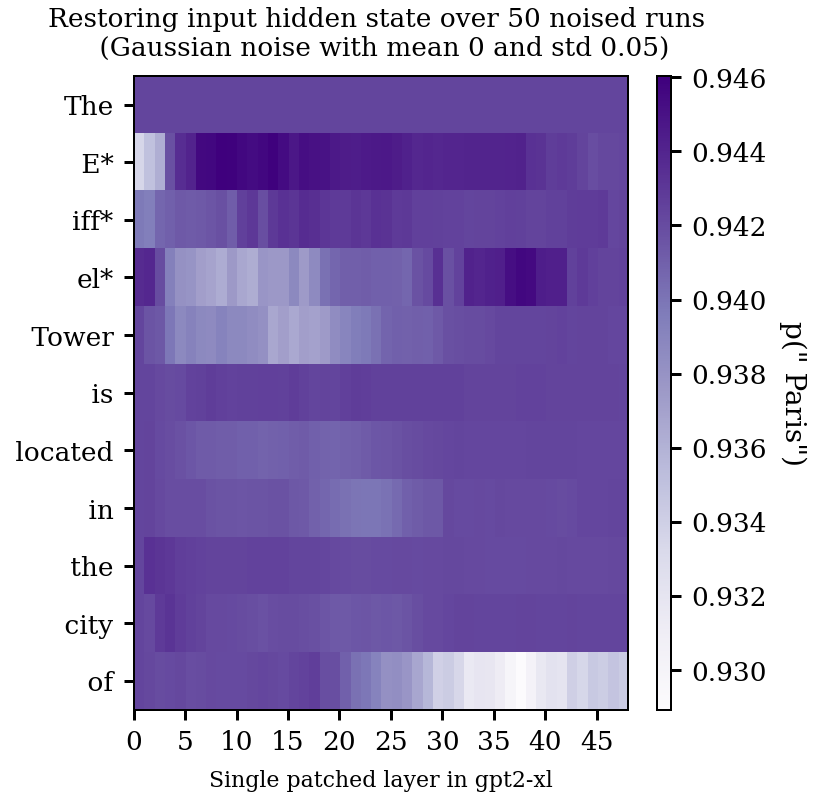

time: 2min 44s (started: 2022-08-26 11:35:19 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "The Eiffel Tower is located in the city of",
                   noise_idxs = [1,2,3],
                   noise_std = 0.05,
                   batch_size = 50)

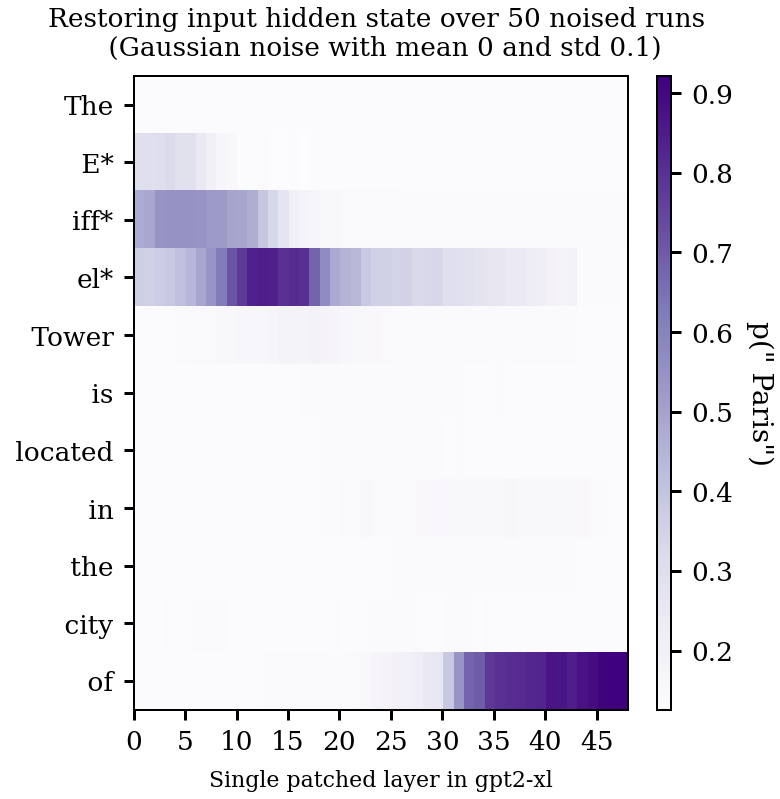

time: 2min 45s (started: 2022-08-26 11:38:03 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "The Eiffel Tower is located in the city of",
                   noise_idxs = [1,2,3],
                   noise_std = 0.1,
                   batch_size = 50)

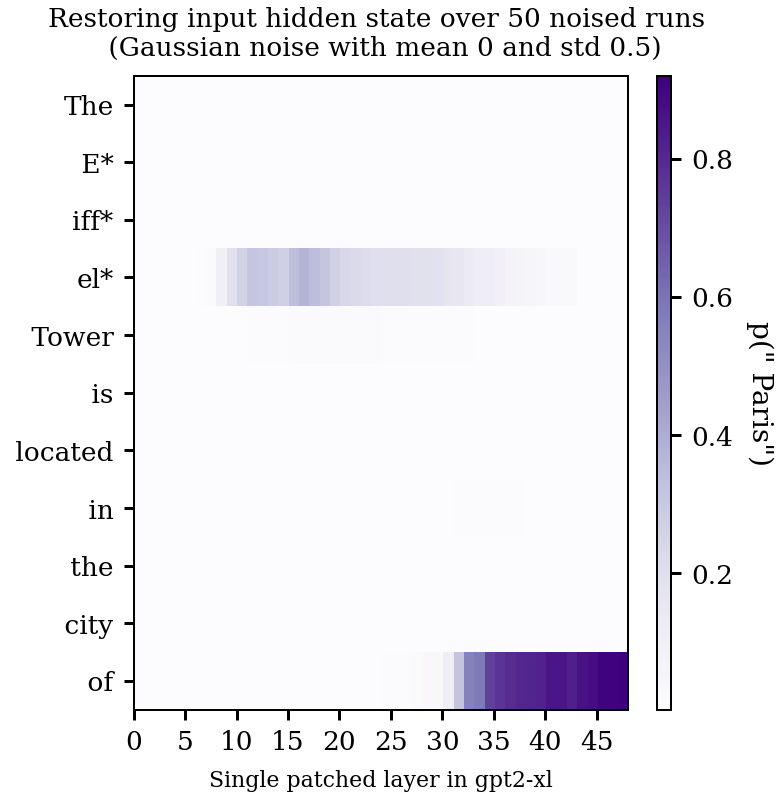

time: 2min 43s (started: 2022-08-26 11:40:49 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "The Eiffel Tower is located in the city of",
                   noise_idxs = [1,2,3],
                   noise_std = 0.5,
                   batch_size = 50)

### (Object Property / Narrative Regurgitation) Glass Shatter (center at ~ layer 35)?

Not really a "right" answer here - could be "broke" for example.

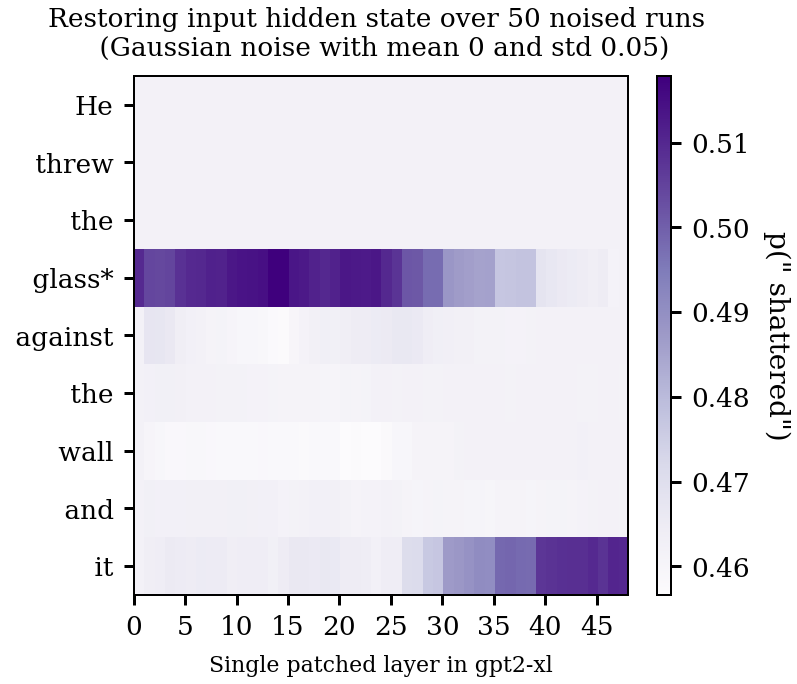

time: 1min 53s (started: 2022-08-26 13:28:45 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "He threw the glass against the wall and it",
                   noise_idxs = [3],
                   noise_std = 0.05,
                   batch_size = 50)

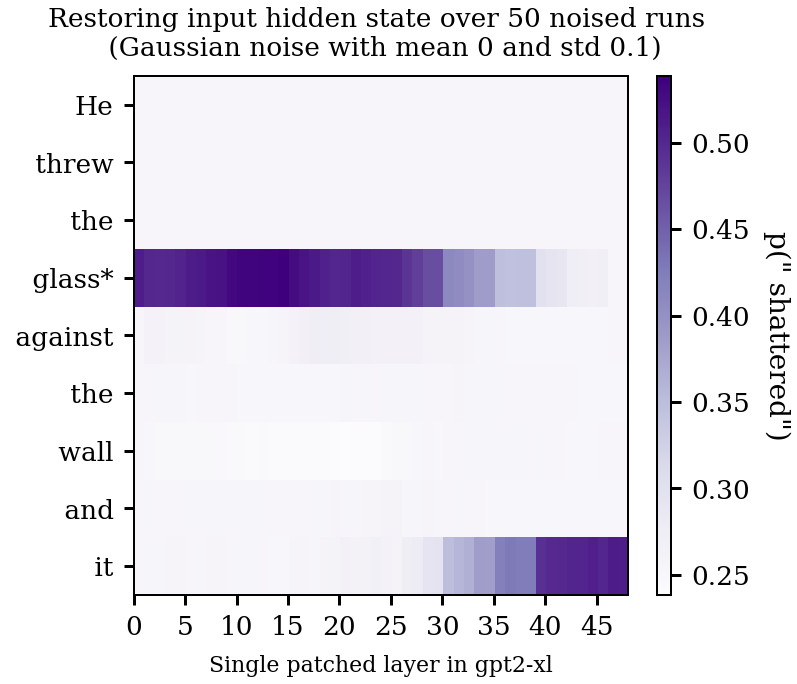

time: 1min 53s (started: 2022-08-26 13:24:40 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "He threw the glass against the wall and it",
                   noise_idxs = [3],
                   noise_std = 0.1,
                   batch_size = 50)

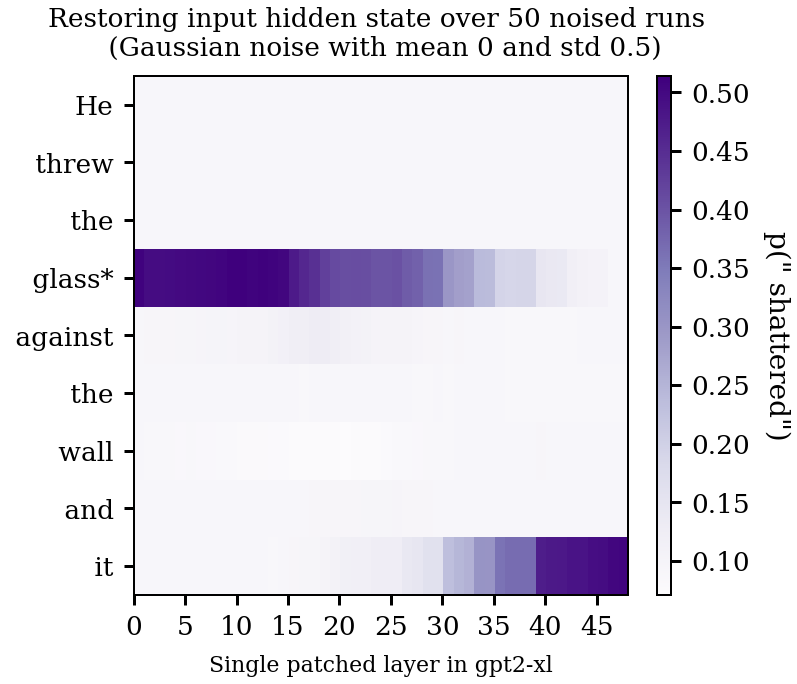

time: 1min 54s (started: 2022-08-26 13:26:50 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "He threw the glass against the wall and it",
                   noise_idxs = [3],
                   noise_std = 0.5,
                   batch_size = 50)

# Hallucinations vs Facts

It seems like hallucinating a fact and recalling a fact can result in very similar causal traces.

If hallucinations are the result of essentially the same factual recall proccess as actual facts then this suggests to me that whatever mechanism is being used for factual recall has something like a continuous input domain. Where we can query 'facts'/associations about any subject - and we get reliable recall about actual factual subjects because learnt facts in some way "anchor" this factual recall function.

I wonder if reliable factual recall would look more like a discrete input function, which only accepts fact recall about actual subjects. It doesn't seem like there is a continuous space of facts, where we can infer a fact halfway between two others (or at least to do so seems like it would require a crazy good understanding of the world). Since it seems like the world is too complicated for GPT2-XL / us to infer every fact, perhaps we should expect reliable recall to be discrete input?

## Hallucinated vs 'Actual' Fact Traces

### Elon's Birthplace

As far as I can tell there arent any especially prominent Elon Smiths

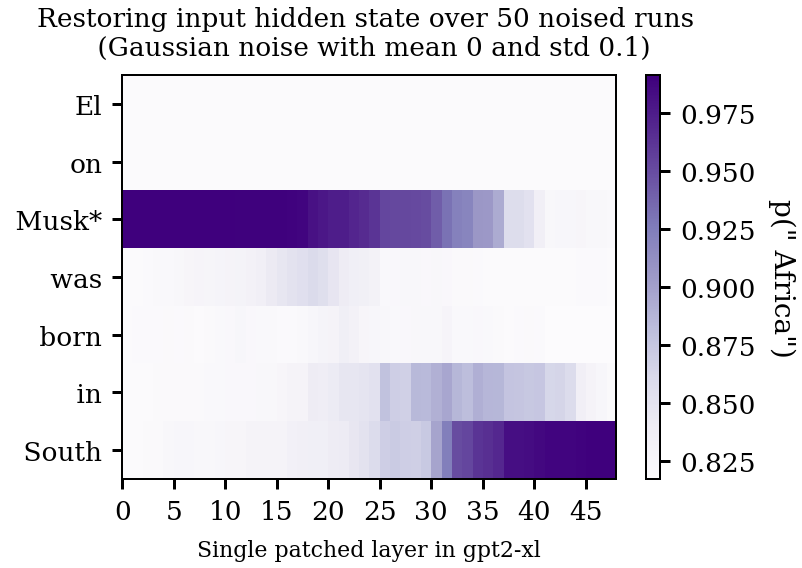

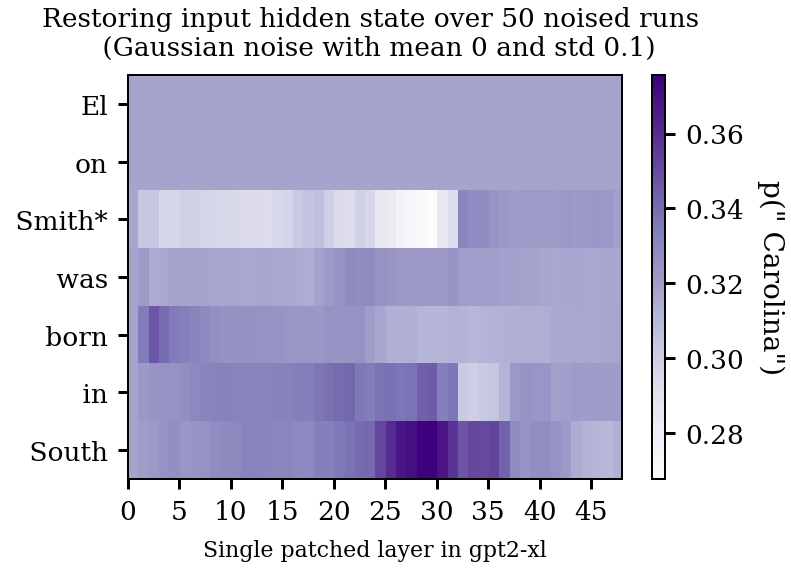

time: 2min 22s (started: 2022-08-26 13:13:44 +00:00)


In [ ]:
text1 = "Elon Musk was born in South"
text2 = "Elon Smith was born in South"
noise_idxs = [2]
noise_std = 0.1

run_and_plot_trace(mt, text1, noise_idxs = noise_idxs, noise_std = noise_std, batch_size = 50)
run_and_plot_trace(mt, text2, noise_idxs = noise_idxs, noise_std = noise_std, batch_size = 50)

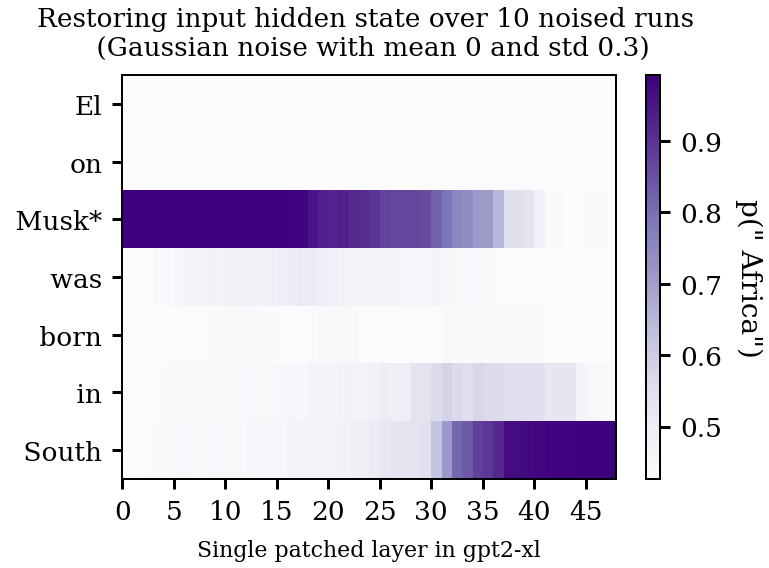

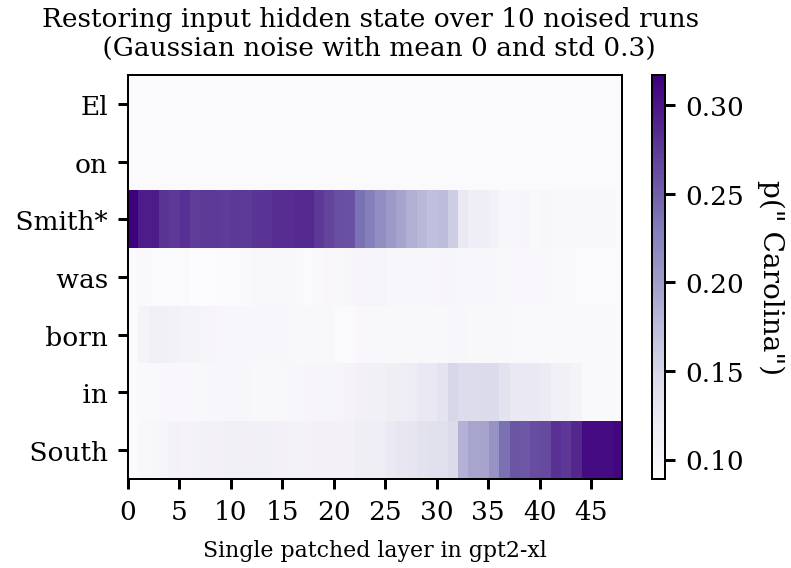

time: 49.1 s (started: 2022-08-25 22:25:30 +00:00)


In [ ]:
text1 = "Elon Musk was born in South"
text2 = "Elon Smith was born in South"
noise_idxs = [2]
noise_std = 0.3

run_and_plot_trace(mt, text1, noise_idxs = noise_idxs, noise_std = noise_std, batch_size = 50)
run_and_plot_trace(mt, text2, noise_idxs = noise_idxs, noise_std = noise_std, batch_size = 50)

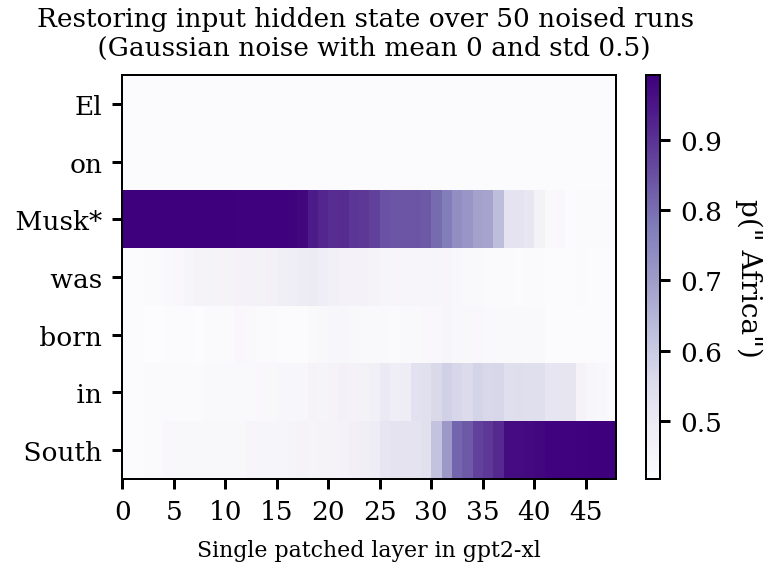

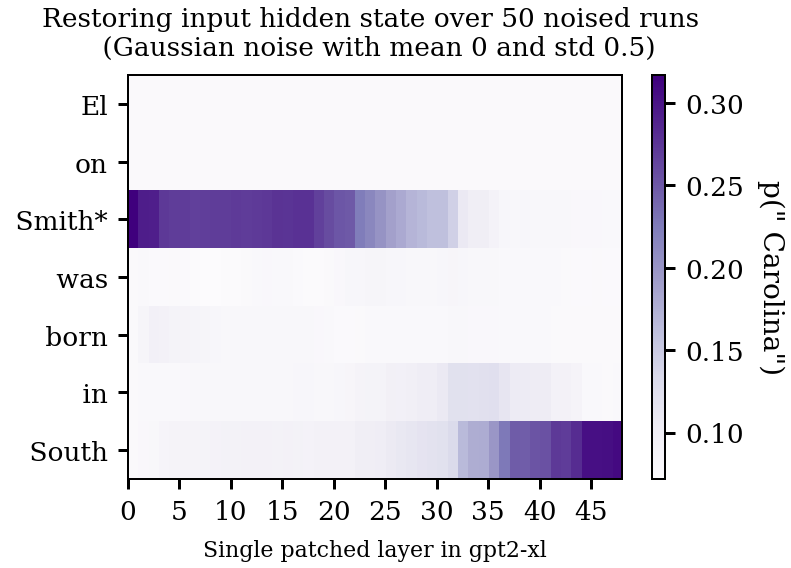

time: 2min 23s (started: 2022-08-26 13:16:06 +00:00)


In [ ]:
text1 = "Elon Musk was born in South"
text2 = "Elon Smith was born in South"
noise_idxs = [2]
noise_std = 0.5

run_and_plot_trace(mt, text1, noise_idxs = noise_idxs, noise_std = noise_std, batch_size = 50)
run_and_plot_trace(mt, text2, noise_idxs = noise_idxs, noise_std = noise_std, batch_size = 50)

### Mark's Birthplace

As far as I can tell there aren't any especially prominent Mark Marsh's, nor does it seem like Marsh is a surname paticularly associated with New Zealand

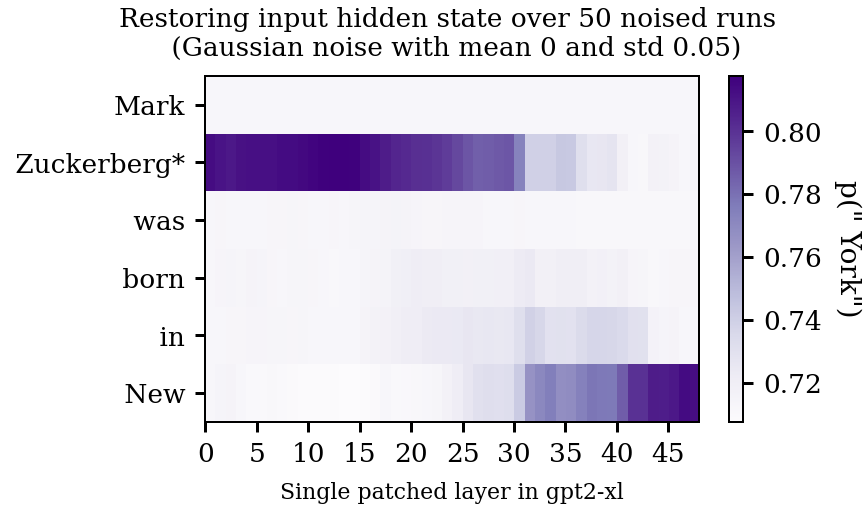

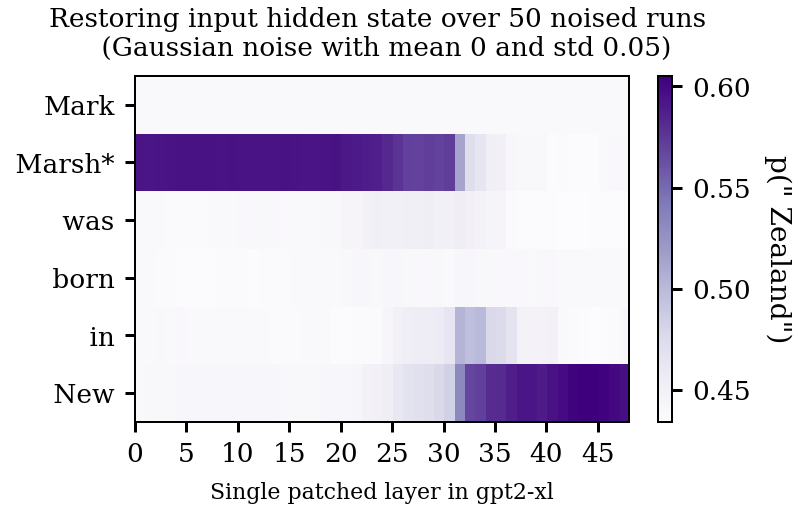

time: 1min 57s (started: 2022-08-26 13:35:12 +00:00)


In [ ]:
text1 = "Mark Zuckerberg was born in New"
text2 = "Mark Marsh was born in New"
noise_idxs = [1]

run_and_plot_trace(mt, text1, noise_idxs = noise_idxs, noise_std = 0.05, batch_size = 50)
run_and_plot_trace(mt, text2, noise_idxs = noise_idxs, noise_std = 0.05, batch_size = 50)

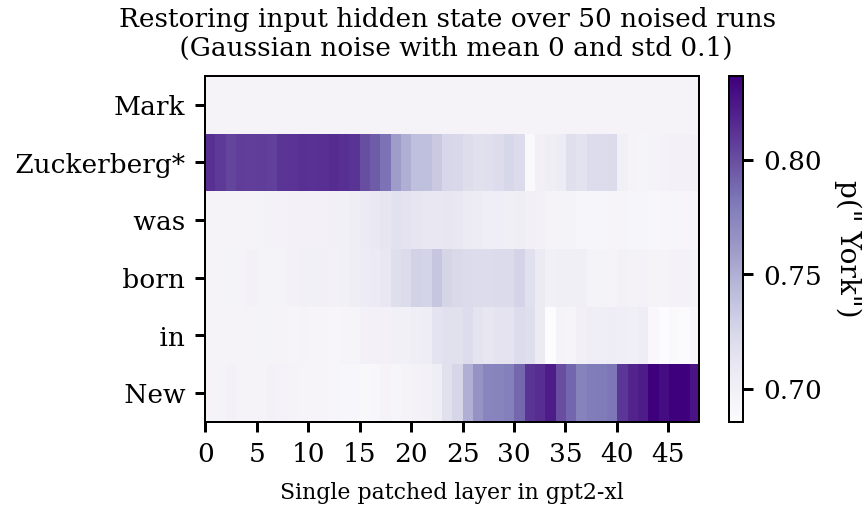

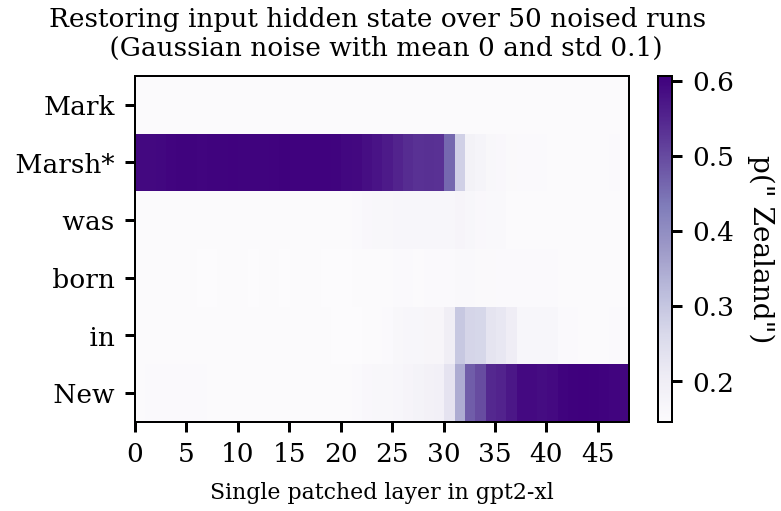

time: 1min 51s (started: 2022-08-25 22:32:21 +00:00)


In [ ]:
text1 = "Mark Zuckerberg was born in New"
text2 = "Mark Marsh was born in New"
noise_idxs = [1]

run_and_plot_trace(mt, text1, noise_idxs = noise_idxs, noise_std = 0.1, batch_size = 50)
run_and_plot_trace(mt, text2, noise_idxs = noise_idxs, noise_std = 0.1, batch_size = 50)

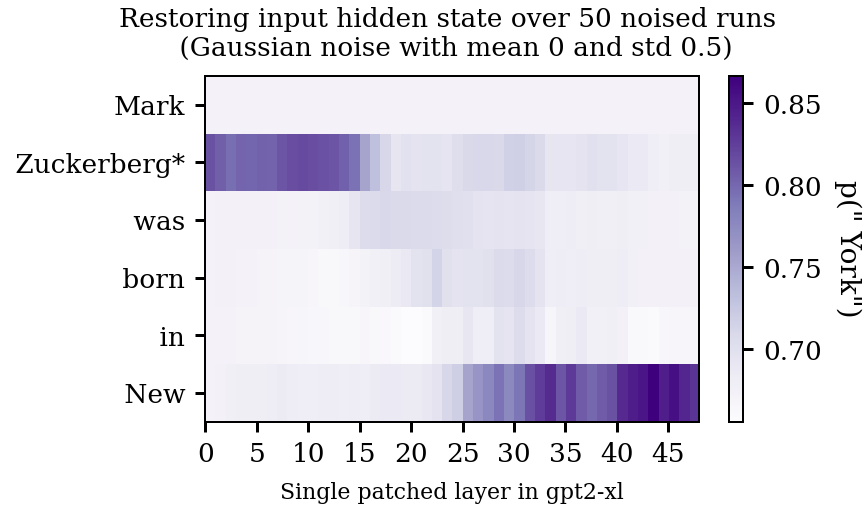

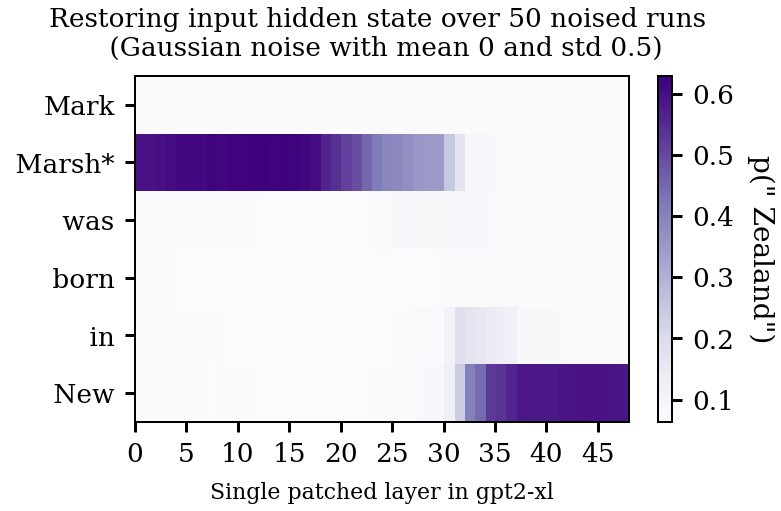

time: 1min 52s (started: 2022-08-26 13:37:09 +00:00)


In [ ]:
text1 = "Mark Zuckerberg was born in New"
text2 = "Mark Marsh was born in New"
noise_idxs = [1]


run_and_plot_trace(mt, text1, noise_idxs = noise_idxs, noise_std = 0.5, batch_size = 50)
run_and_plot_trace(mt, text2, noise_idxs = noise_idxs, noise_std = 0.5, batch_size = 50)

### Fake Famous Tower

(There is a not paticularly well known great eastern tower in Kuala Lumpur)
 https://en.wikipedia.org/wiki/Great_Eastern_Tower

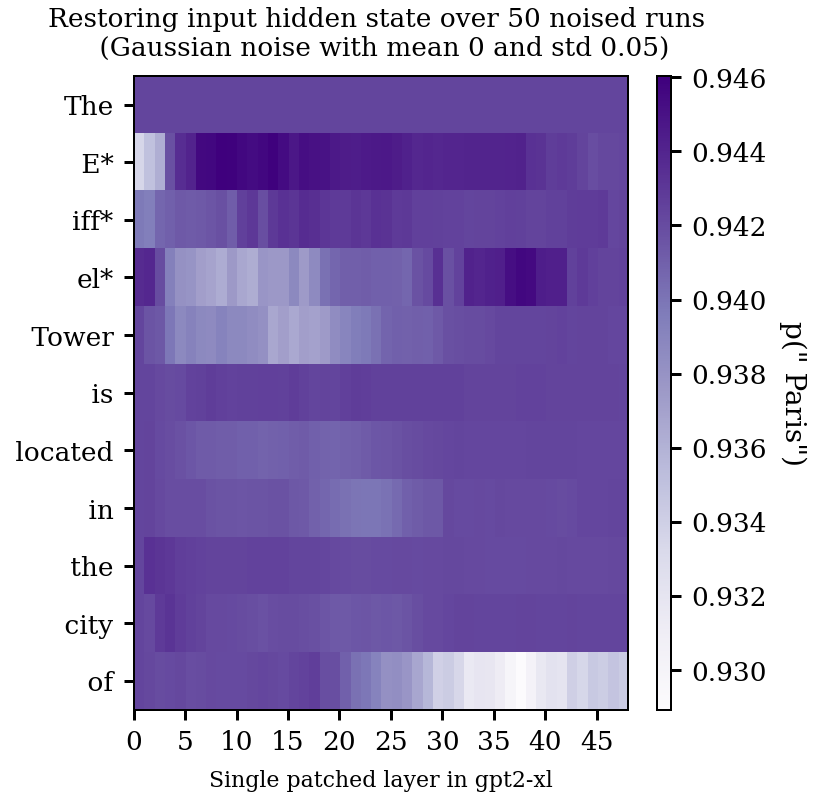

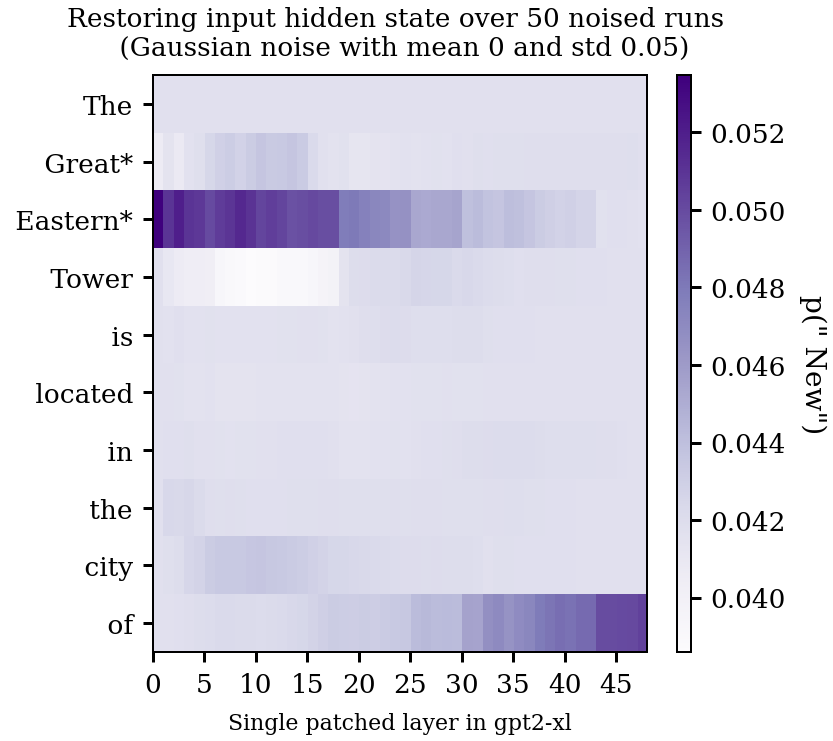

time: 4min 54s (started: 2022-08-26 13:39:03 +00:00)


In [ ]:
text1 = "The Eiffel Tower is located in the city of"
text2 = "The Great Eastern Tower is located in the city of"
noise_std = 0.05
bs = 50

run_and_plot_trace(mt, text1, noise_idxs = [1,2,3], noise_std = noise_std, batch_size = bs)
run_and_plot_trace(mt, text2, noise_idxs = [1,2], noise_std = noise_std, batch_size = bs)

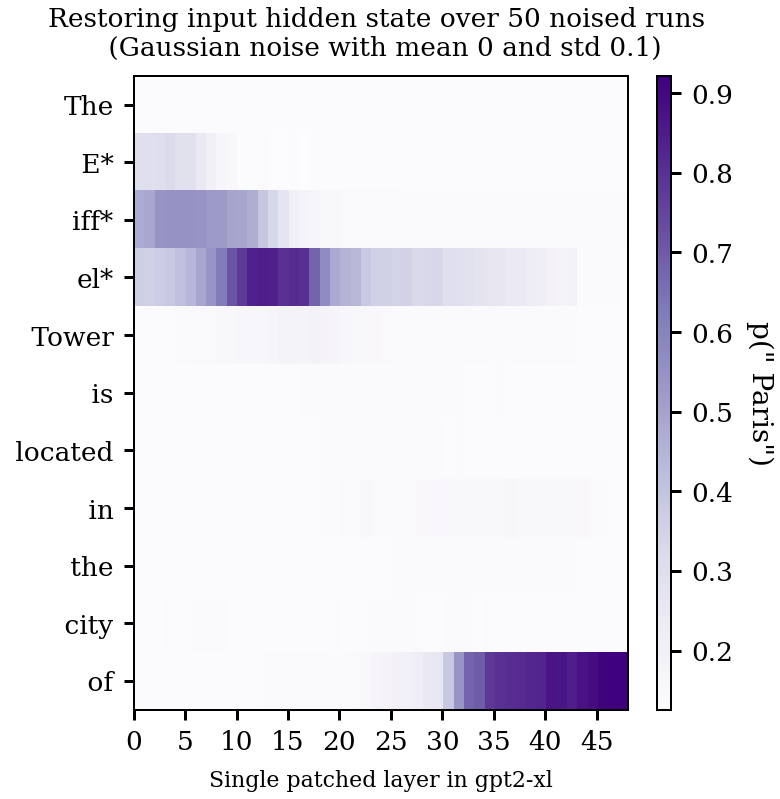

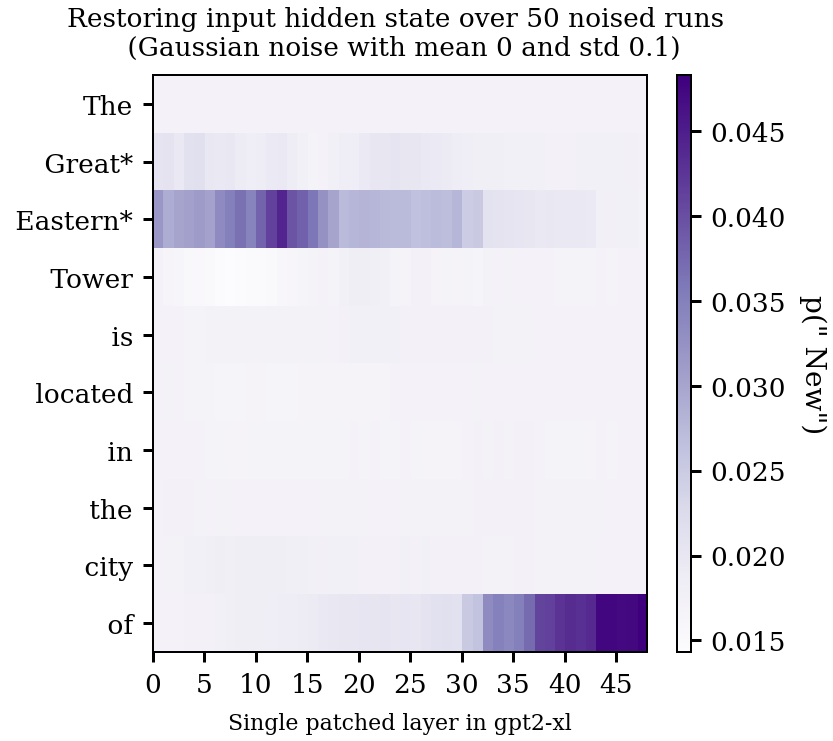

time: 4min 51s (started: 2022-08-26 13:43:58 +00:00)


In [ ]:
text1 = "The Eiffel Tower is located in the city of"
text2 = "The Great Eastern Tower is located in the city of"
noise_std = 0.1
run_and_plot_trace(mt, text1, noise_idxs = [1,2,3], noise_std = noise_std, batch_size = bs)
run_and_plot_trace(mt, text2, noise_idxs = [1,2], noise_std = noise_std, batch_size = bs)

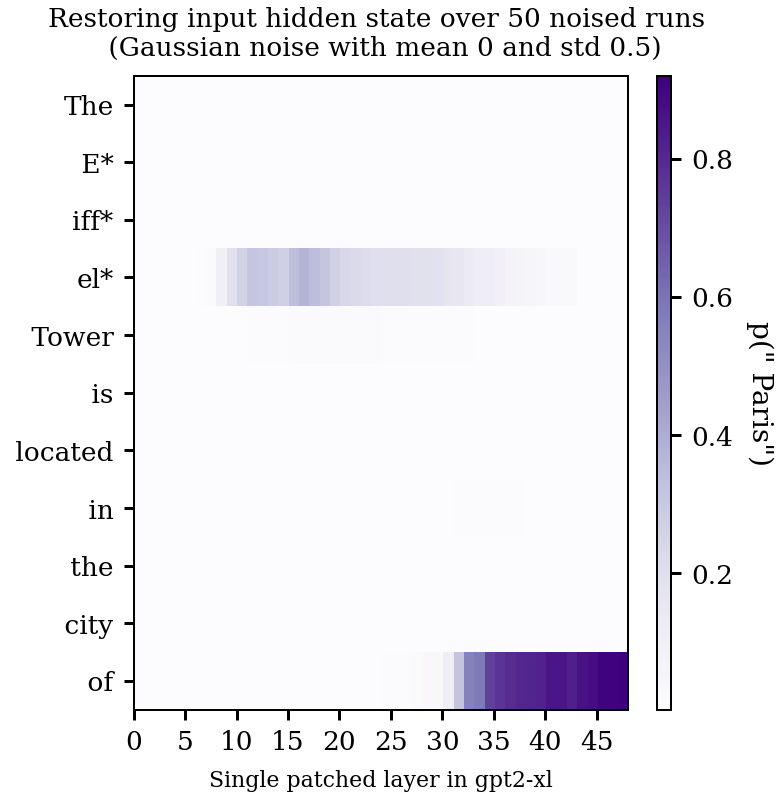

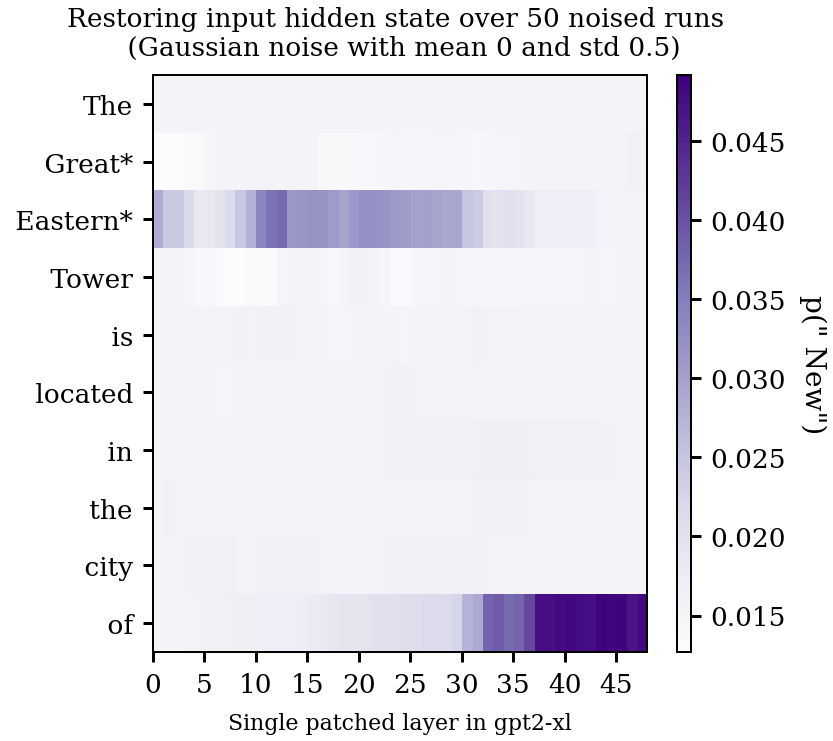

time: 4min 51s (started: 2022-08-26 13:48:49 +00:00)


In [ ]:
text1 = "The Eiffel Tower is located in the city of"
text2 = "The Great Eastern Tower is located in the city of"
noise_std = 0.5
run_and_plot_trace(mt, text1, noise_idxs = [1,2,3], noise_std = noise_std, batch_size = bs)
run_and_plot_trace(mt, text2, noise_idxs = [1,2], noise_std = noise_std, batch_size = bs)

# **[ROUGH / WIP EXPERIMENTING]**

# For Low Noise Levels Patching Can Be Harmful? Just Low Signal to Noise or Different Behaviour?

Most of the time (with high enough noise levels), patching in the hidden state from a forawrd pass with clean inputs is helpful for the processing of the noised inputs. However, sometimes when the noise level is low enough patching in the hidden state can become harmful - and often it is most harmful in the places it was previously helpful. Though usually these effects are quite small, as lower noise levels results in tighter probability ranges.

[Speculation] One possible explanation for this is that the relevant patches are paticularly sensitive to being patched, and that for some small enough noise level, the network is more robust to a consistent noise in the input embeddings than it is to an abrupt change of state halfway through processing? e.g Perhaps this abrupt change could mess up operations that compare state in different places?

### Examples of Patching Inversion

#### Eiffel Tower

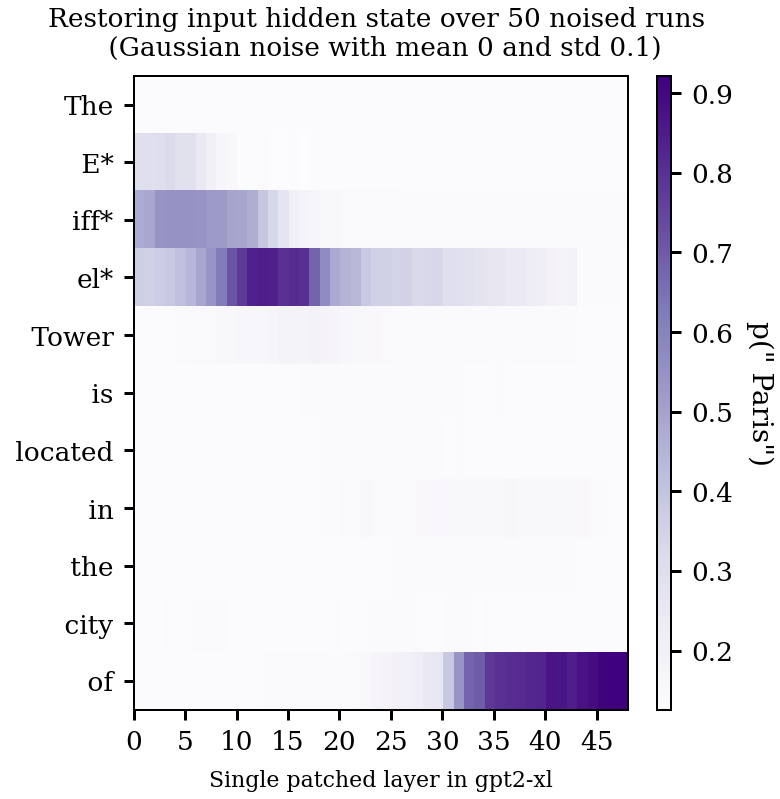

time: 2min 45s (started: 2022-08-26 11:38:03 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "The Eiffel Tower is located in the city of",
                   noise_idxs = [1,2,3],
                   noise_std = 0.1,
                   batch_size = 50)

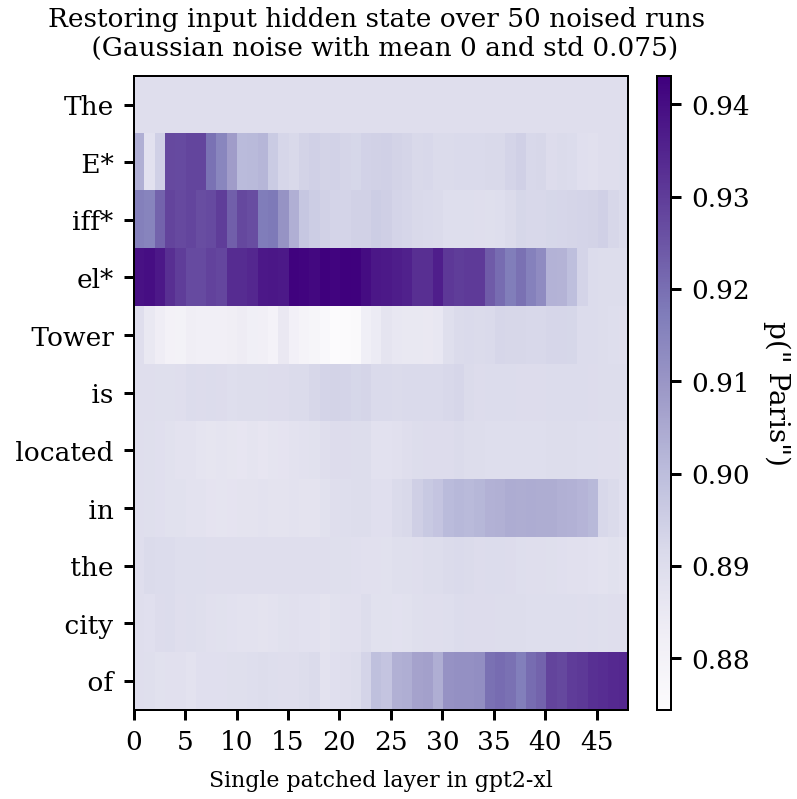

time: 2min 47s (started: 2022-08-26 11:54:15 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "The Eiffel Tower is located in the city of",
                   noise_idxs = [1,2,3],
                   noise_std = 0.075,
                   batch_size = 50)

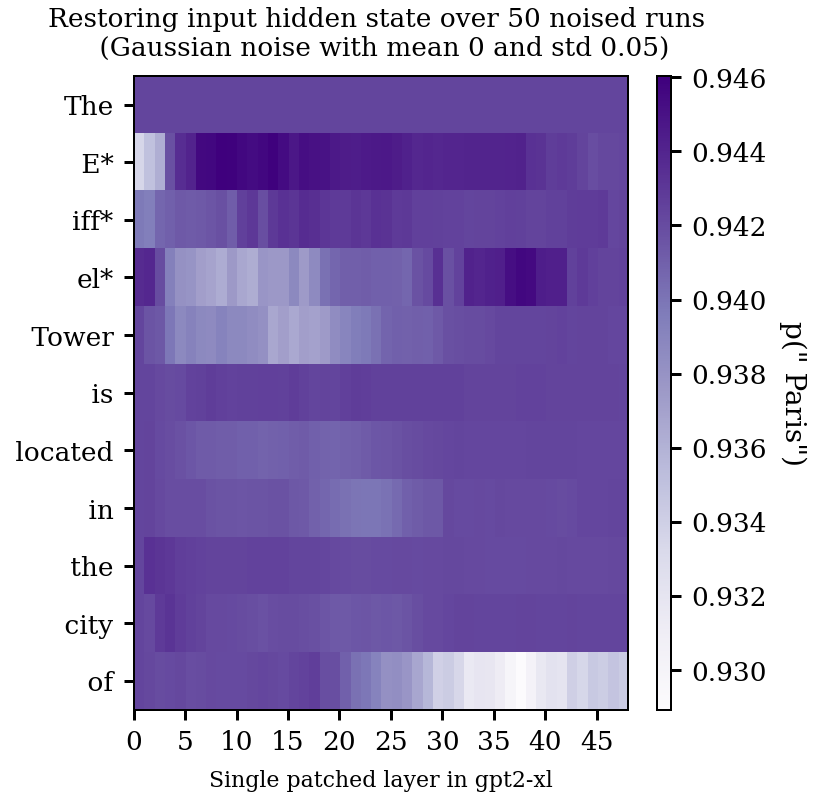

time: 2min 44s (started: 2022-08-26 11:35:19 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "The Eiffel Tower is located in the city of",
                   noise_idxs = [1,2,3],
                   noise_std = 0.05,
                   batch_size = 50)

# Repitition

## Many a Mary (varying sequence length)

In [ ]:
noise_std = 0.3
batch_size = 50

time: 679 µs (started: 2022-08-25 23:29:04 +00:00)


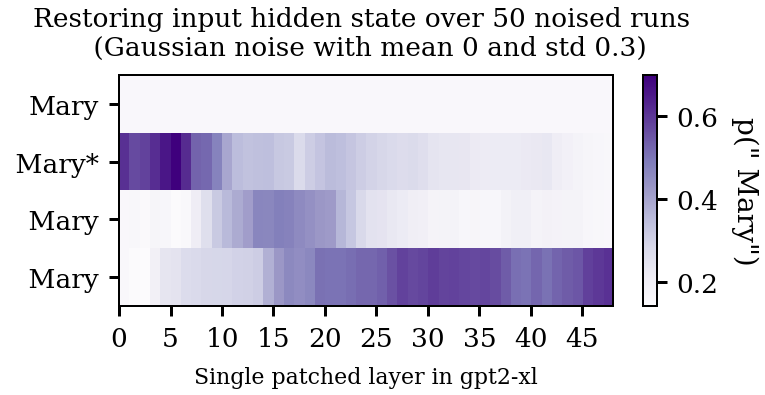

time: 27.3 s (started: 2022-08-25 23:22:14 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "Mary Mary Mary Mary",
                   noise_idxs = [1],
                   noise_std = noise_std,
                   batch_size = batch_size)

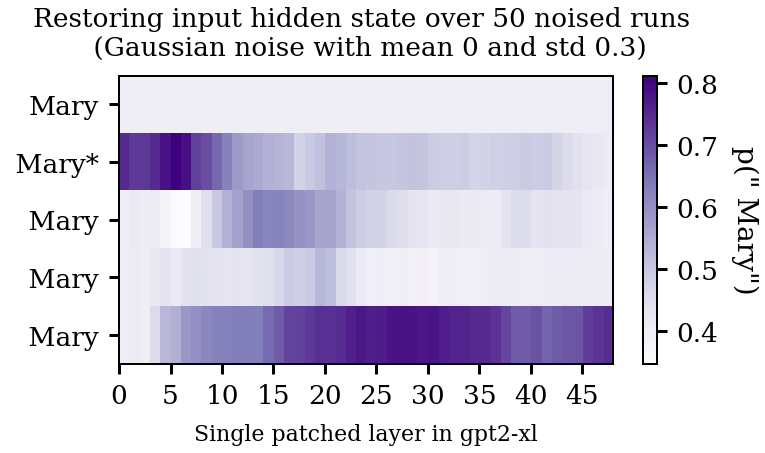

time: 39.6 s (started: 2022-08-25 23:29:06 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "Mary Mary Mary Mary Mary",
                   noise_idxs = [1],
                   noise_std = noise_std,
                   batch_size = batch_size)

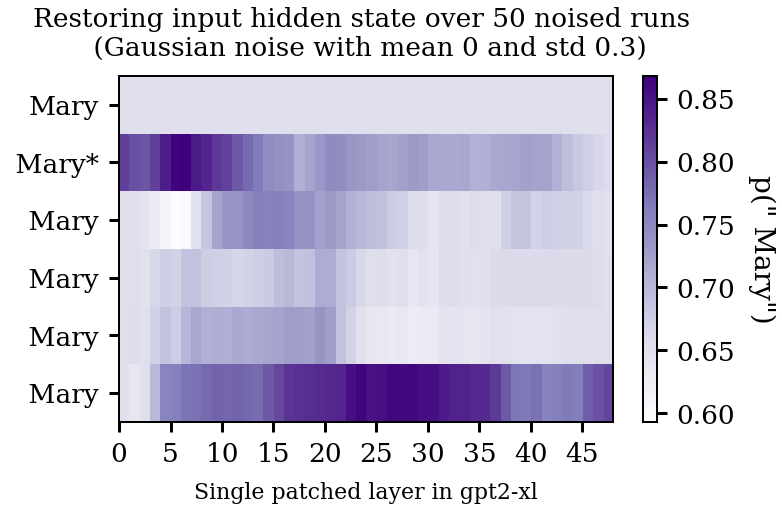

time: 1min (started: 2022-08-25 23:29:46 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "Mary Mary Mary Mary Mary Mary",
                   noise_idxs = [1],
                   noise_std = noise_std,
                   batch_size = batch_size)

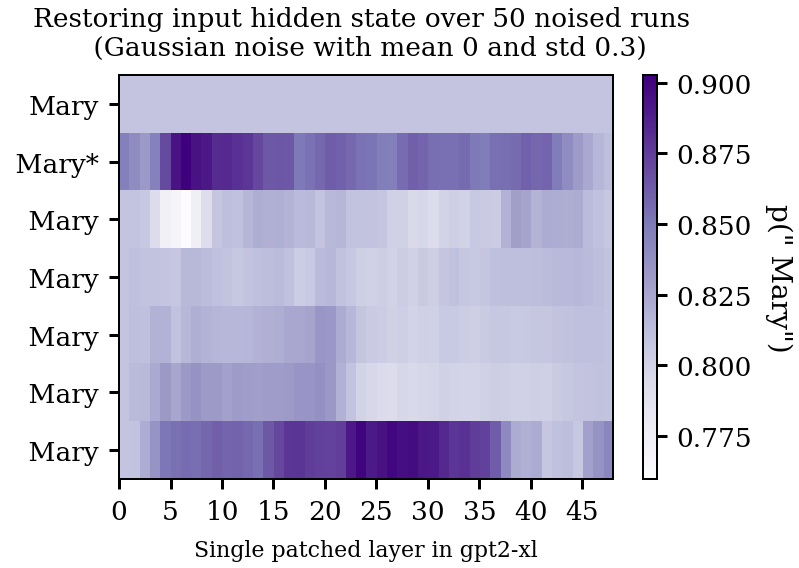

time: 1min 14s (started: 2022-08-25 23:30:48 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "Mary Mary Mary Mary Mary Mary Mary",
                   noise_idxs = [1],
                   noise_std = noise_std,
                   batch_size = batch_size)

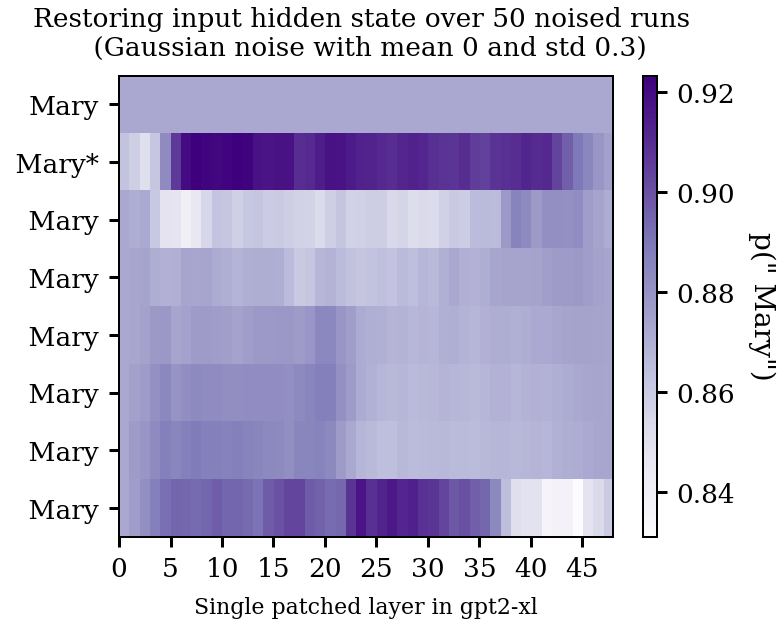

time: 1min 38s (started: 2022-08-25 23:48:00 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "Mary Mary Mary Mary Mary Mary Mary Mary",
                   noise_idxs = [1],
                   noise_std = noise_std,
                   batch_size = batch_size)

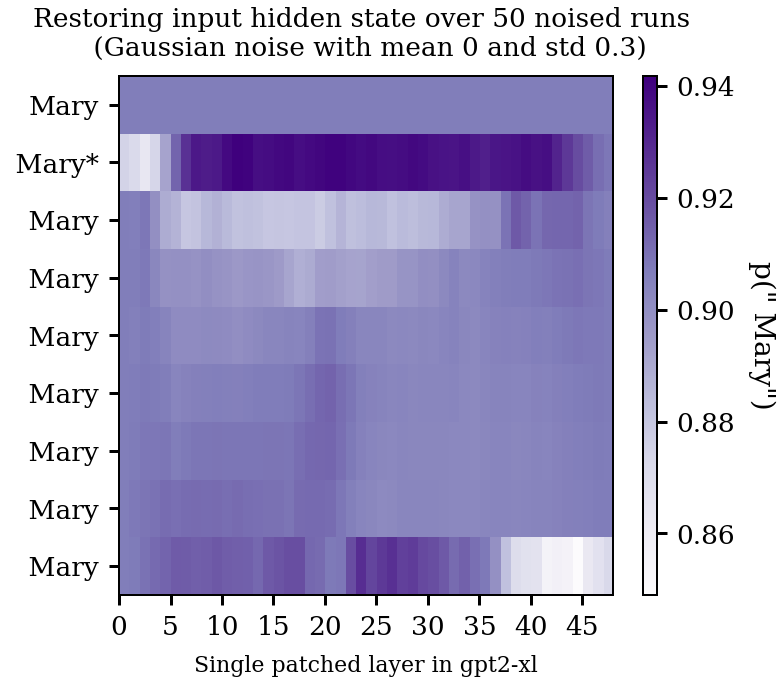

time: 1min 54s (started: 2022-08-25 23:49:39 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "Mary Mary Mary Mary Mary Mary Mary Mary Mary",
                   noise_idxs = [1],
                   noise_std = noise_std,
                   batch_size = batch_size)

## Many a Mary (varying sequence length whilst scaling noise to try and preserve probability range)

In [ ]:
batch_size = 50

time: 663 µs (started: 2022-08-25 23:51:34 +00:00)


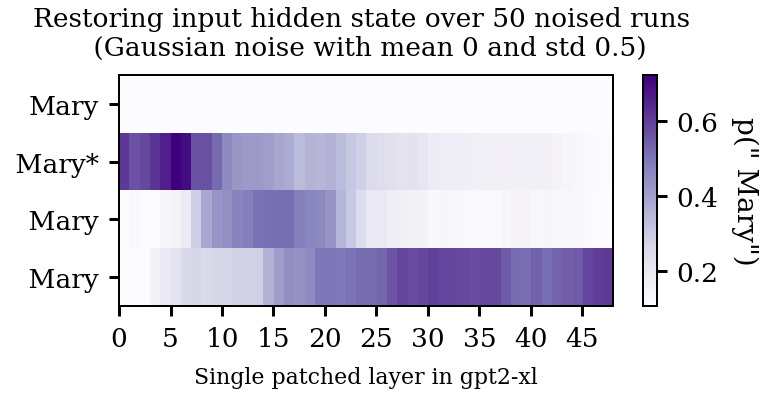

time: 27.5 s (started: 2022-08-25 23:51:35 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "Mary Mary Mary Mary",
                   noise_idxs = [1],
                   noise_std = 0.5,
                   batch_size = batch_size)

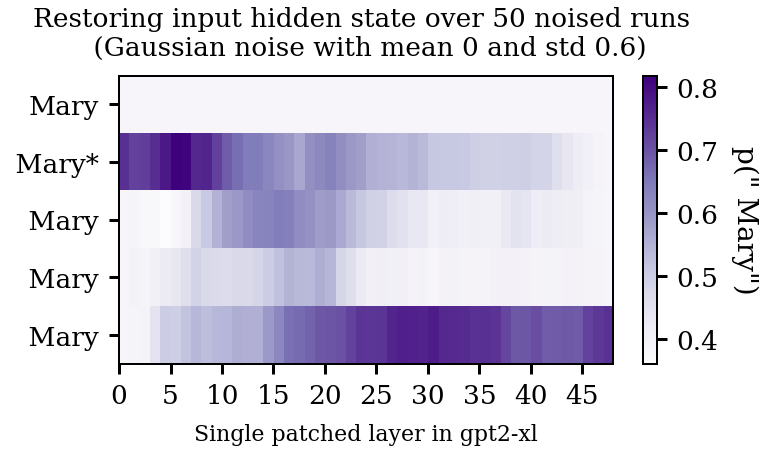

time: 36 s (started: 2022-08-25 23:52:02 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "Mary Mary Mary Mary Mary",
                   noise_idxs = [1],
                   noise_std = 0.6,
                   batch_size = batch_size)

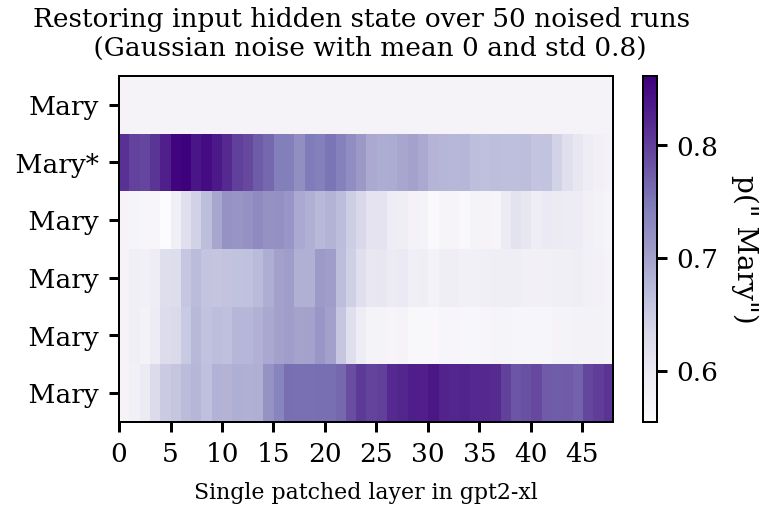

time: 55.2 s (started: 2022-08-25 23:56:23 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "Mary Mary Mary Mary Mary Mary",
                   noise_idxs = [1],
                   noise_std = 0.8,
                   batch_size = batch_size)

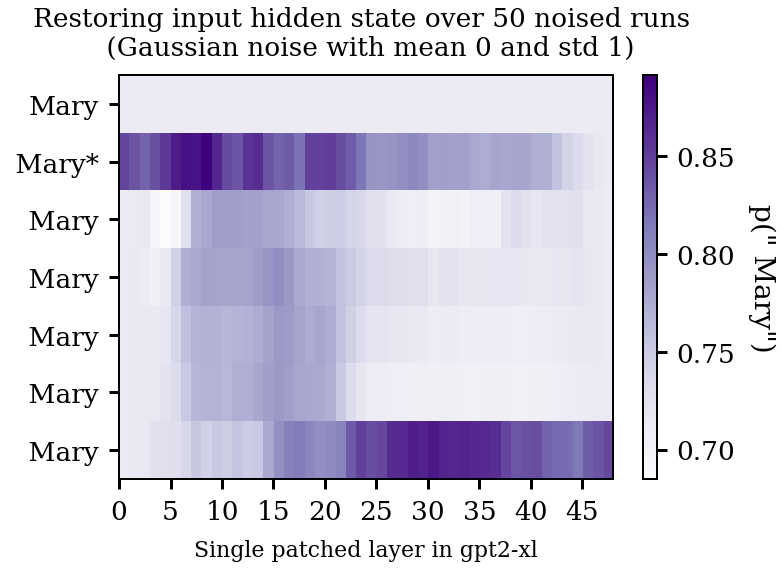

time: 1min 9s (started: 2022-08-25 23:57:18 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "Mary Mary Mary Mary Mary Mary Mary",
                   noise_idxs = [1],
                   noise_std = 1,
                   batch_size = batch_size)

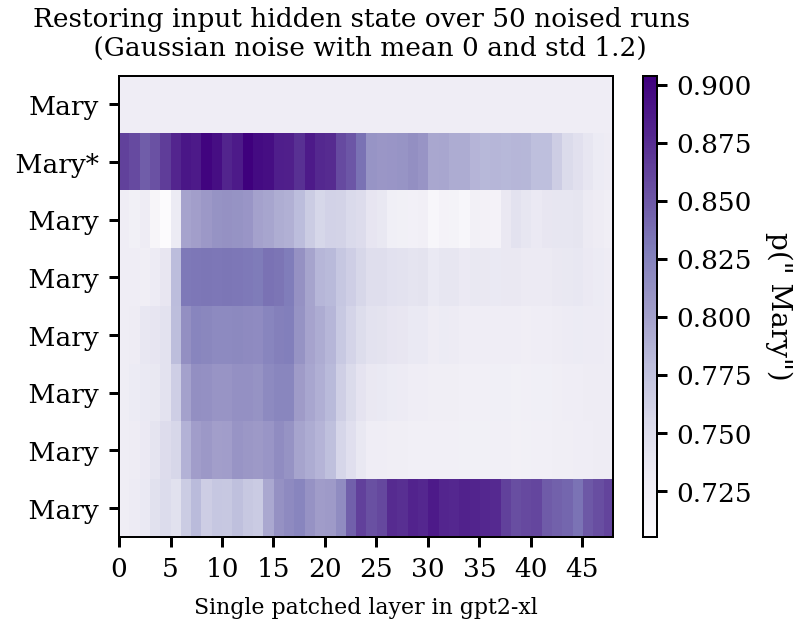

time: 1min 37s (started: 2022-08-25 23:58:28 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "Mary Mary Mary Mary Mary Mary Mary Mary",
                   noise_idxs = [1],
                   noise_std = 1.2,
                   batch_size = batch_size)

## Many a Mary (scaling min based on prob under noised input, and scaling max based on prob under clean input) - [need to check whether scaling func is right]

In [ ]:
batch_size = 50
noise_std = 0.3

time: 712 µs (started: 2022-08-26 00:48:23 +00:00)


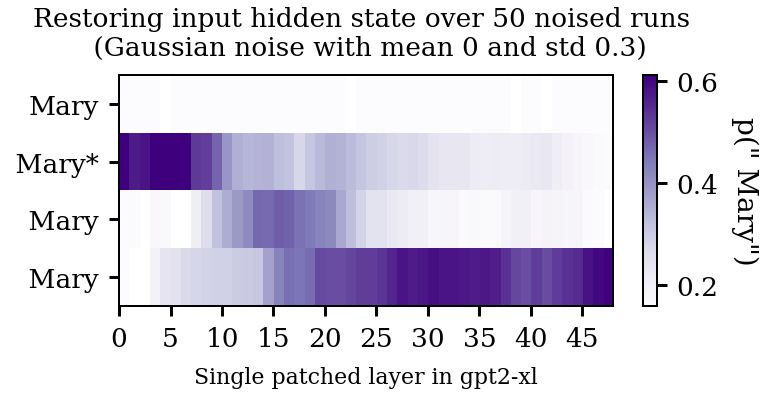

time: 27.4 s (started: 2022-08-26 00:52:40 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "Mary Mary Mary Mary",
                   noise_idxs = [1],
                   noise_std = noise_std,
                   batch_size = batch_size, mod_min_max = True)

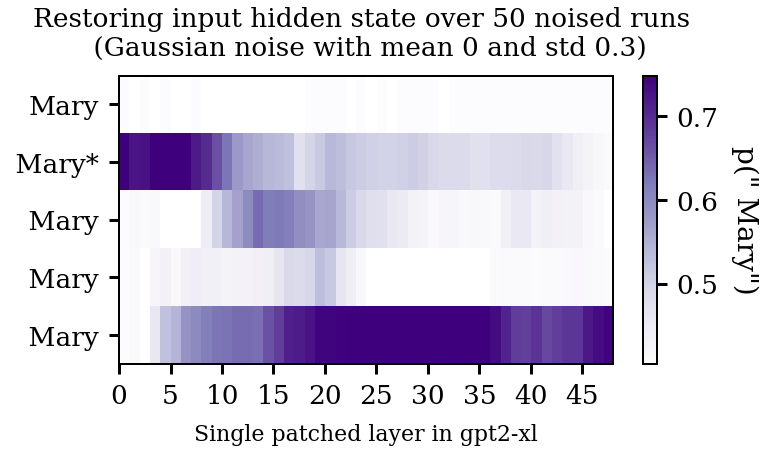

time: 36.1 s (started: 2022-08-26 00:48:23 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "Mary Mary Mary Mary Mary",
                   noise_idxs = [1],
                   noise_std = noise_std,
                   batch_size = batch_size,
                   mod_min_max = True)

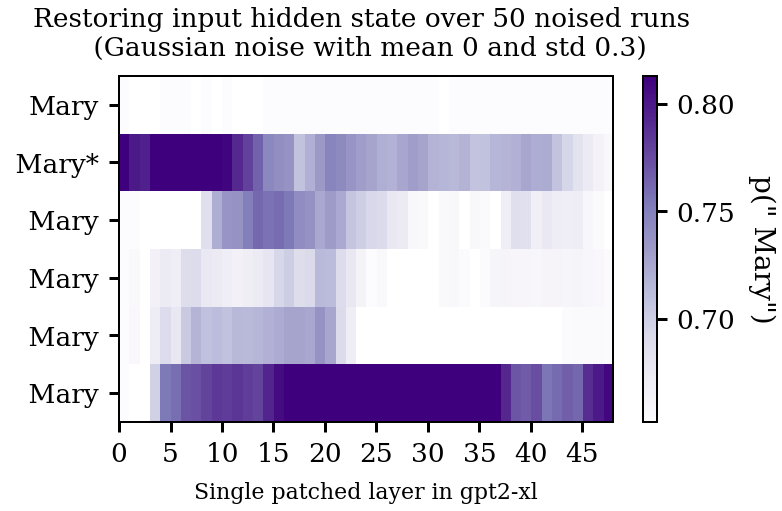

time: 55.2 s (started: 2022-08-26 00:48:59 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "Mary Mary Mary Mary Mary Mary",
                   noise_idxs = [1],
                   noise_std = noise_std,
                   batch_size = batch_size,
                   mod_min_max = True)

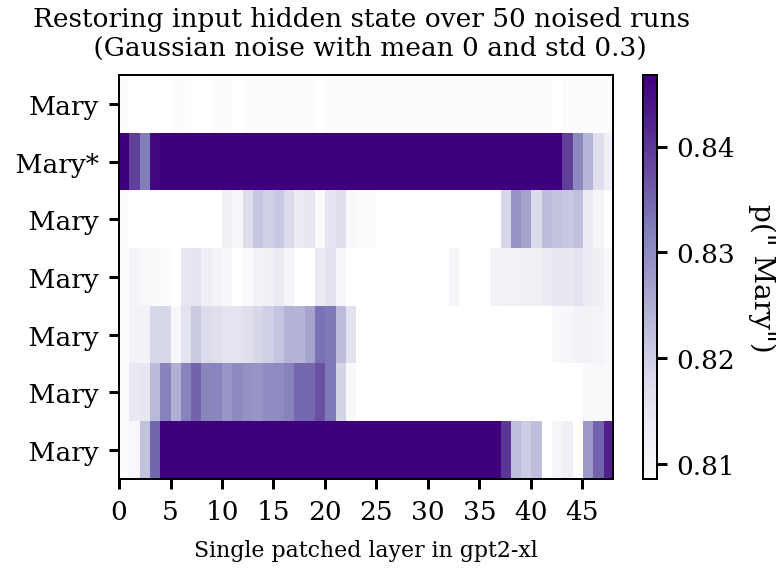

time: 1min 9s (started: 2022-08-26 00:49:54 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "Mary Mary Mary Mary Mary Mary Mary",
                   noise_idxs = [1],
                   noise_std = noise_std,
                   batch_size = batch_size,
                   mod_min_max = True)

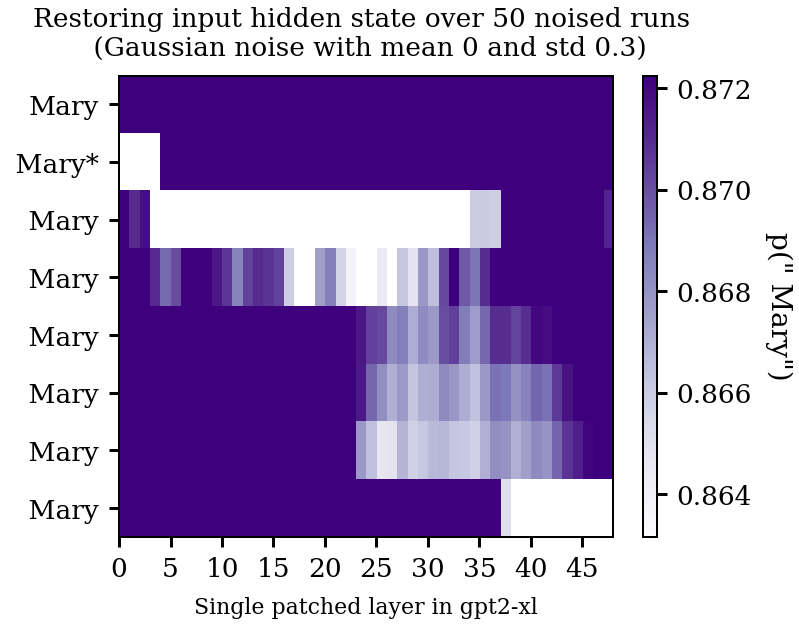

time: 1min 35s (started: 2022-08-26 00:51:04 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "Mary Mary Mary Mary Mary Mary Mary Mary",
                   noise_idxs = [1],
                   noise_std = noise_std,
                   batch_size = batch_size,
                   mod_min_max = True)

# Multi Token Word 'Draining' Into Last Token?

I thought this output was nice, it looks a bit like you can see the accumlation of Eiffel-ness happening through the processing of the word. Not that this is necessarily a good description of what is actually going on, but I did think it was neat.

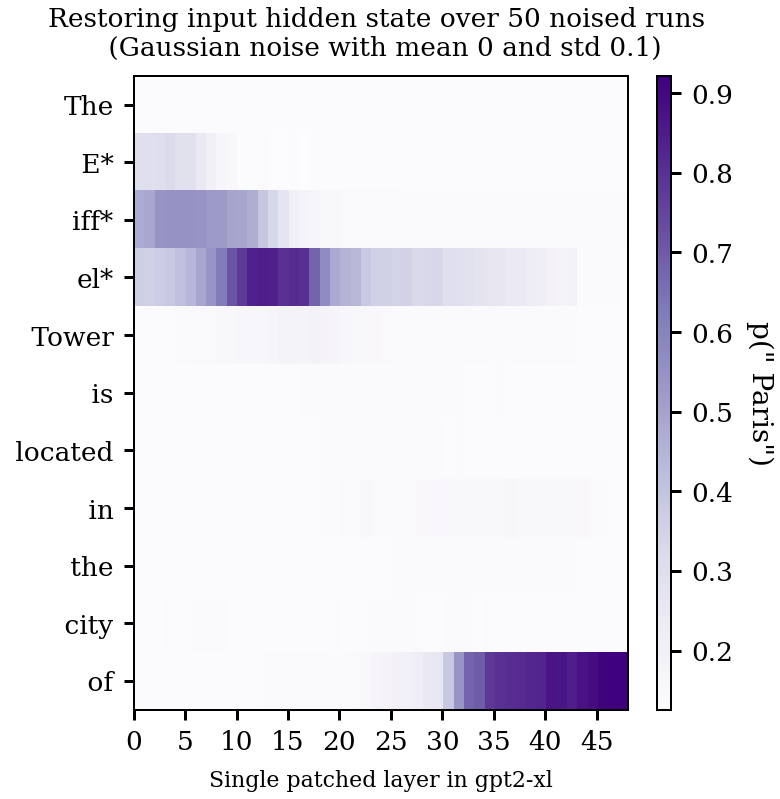

time: 2min 45s (started: 2022-08-26 11:38:03 +00:00)


In [ ]:
run_and_plot_trace(mt,
                   "The Eiffel Tower is located in the city of",
                   noise_idxs = [1,2,3],
                   noise_std = 0.1,
                   batch_size = 50)